# Unusual Repeated Streak (QAQC)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import datetime as dt
import scipy
from IPython.display import Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

## From HadISD paper:

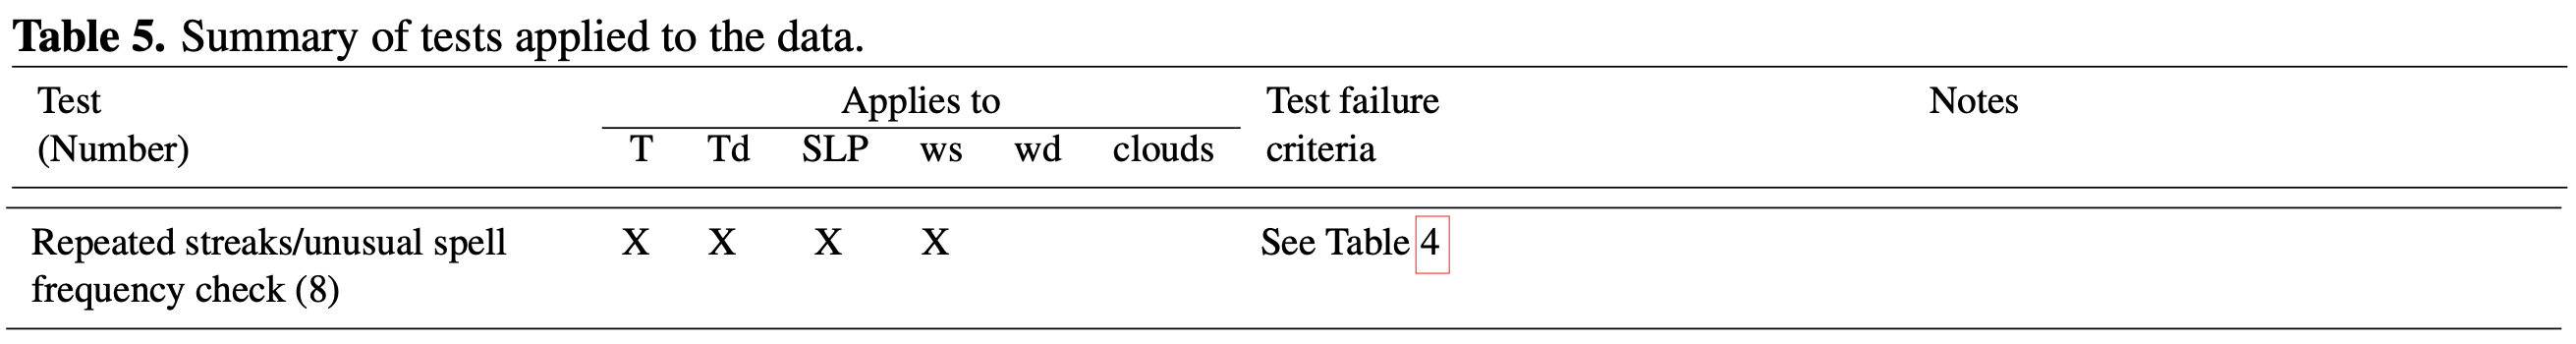

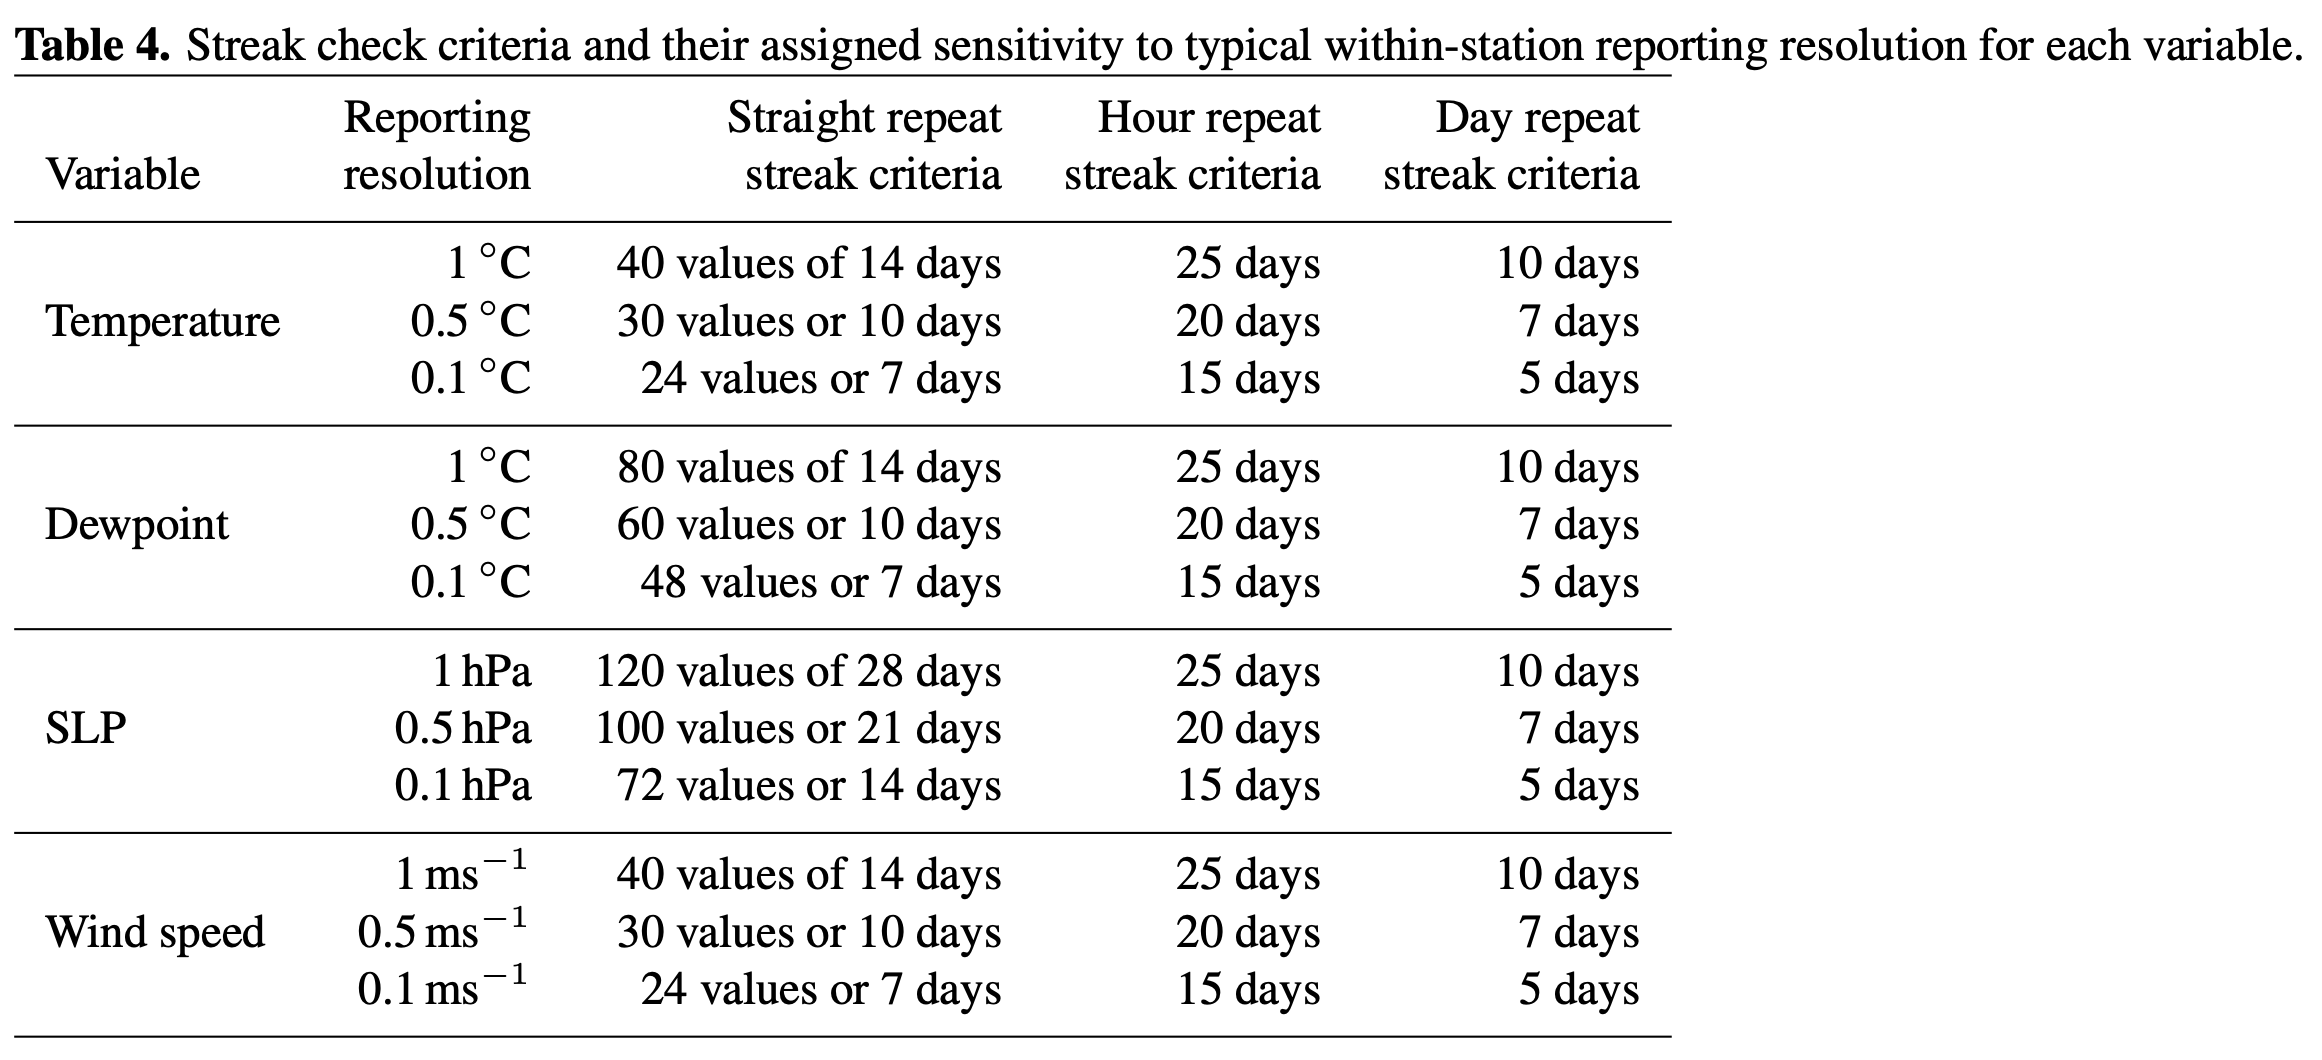

In [2]:
display(Image(filename="/Users/hector/ERA_work/Table5.png"))
display(Image(filename="/Users/hector/ERA_work/Table4.png"))

##### Test 8: repeated streaks/unusual spell frequency

<div style="display: flex;">
    <span style="width: 59%"><p size="+4.75">This test searches for consecutive observation replication, same hour observation replication over, a number of days (either using a threshold of a certain number of observations, or for sparser records, a number of days during which all the observations have the same value) and also whole day replication for a streak of days. All three tests are conditional upon the typical reporting precision as coarser precision reporting (e.g. temperatures only to the nearest whole degree) will increase the chances of a streak arising by chance (Table 4).</p></span> 
</div>


In [3]:
#---------------------------------------------------------------------------------------------------
def qaqc_world_record(df, verbose=True):
    '''
    Checks if temperature, dewpoint, windspeed, or sea level pressure are outside North American world records
    If outside minimum or maximum records, flags values
    '''
    try:
        # world records from HadISD protocol, cross-checked with WMO database
        # https://wmo.asu.edu/content/world-meteorological-organization-global-weather-climate-extremes-archive
        T_X = {"North_America":329.92} #K
        T_N = {"North_America":210.15} #K
        D_X = {"North_America":329.85} #K
        D_N = {"North_America":173.15} #K
        W_X = {"North_America":113.2} #m/s
        W_N = {"North_America":0.} #m/s
        S_X = {"North_America":108330} #Pa
        S_N = {"North_America":87000} #Pa

        maxes = {"tas": T_X, "tdps": D_X, "tdps_derived": D_X, "sfcWind": W_X, "psl": S_X, "ps": S_X}
        mins =  {"tas": T_N, "tdps": D_N, "tdps_derived": D_N, "sfcWind": W_N, "psl": S_N, "ps": S_N}

        # variable names to check against world record limits
        wr_vars = ['tas', 'tdps_derived', 'tdps', 'sfcWind', 'psl', 'ps']

        for var in wr_vars:
            if var in list(df.columns):
                                
                isOffRecord = np.logical_or(df[var] < mins[var]['North_America'],
                                            df[var] > maxes[var]['North_America'])
                if isOffRecord.any():
                    df.loc[isOffRecord, var + '_eraqc'] = 11
        return df
    except Exception as e:
        if verbose:
            print("qaqc_world_record failed with Exception: {}".format(e))
        return None
    

In [73]:
def xarray_to_pandas_qaqc_old(ds):
    """
    """

    ## Add qc_flag variable for all variables, including elevation; 
    ## defaulting to nan for fill value that will be replaced with qc flag
    exclude_qaqc = ["time", "station", "lat", "lon", 
                    "qaqc_process", "sfcWind_method"] # lat and lon have a different qc check

    raw_qc_vars = [] # qc_variable for each data variable, will vary station to station
    era_qc_vars = [] # our qc variable
    for var in ds.data_vars:
        if 'q_code' in var:
            raw_qc_vars.append(var) # raw qc variable, need to keep for comparison, then drop
        if '_qc' in var:
            raw_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars:
            qc_var = var + "_eraqc" # variable/column label
            era_qc_vars.append(qc_var)
            # adds new variable in shape of original variable with designated nan fill value
            ds = ds.assign({qc_var: xr.ones_like(ds[var])*np.nan})

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var:ds[var].attrs for var in list(ds.data_vars.keys())}

    df = ds.to_dataframe()
    df['anemometer_height_m'] = np.ones(ds['time'].shape)*ds.anemometer_height_m
    df['thermometer_height_m'] = np.ones(ds['time'].shape)*ds.thermometer_height_m
    
    return df

In [64]:
def xarray_to_pandas_qaqc(ds):
    """
    """

    ## Add qc_flag variable for all variables, including elevation; 
    ## defaulting to nan for fill value that will be replaced with qc flag
    exclude_qaqc = ["time", "station", "lat", "lon", 
                    "qaqc_process", "sfcWind_method"] # lat and lon have a different qc check

    raw_qc_vars = [] # qc_variable for each data variable, will vary station to station
    era_qc_vars = [] # our qc variable
    for var in ds.data_vars:
        if 'q_code' in var:
            raw_qc_vars.append(var) # raw qc variable, need to keep for comparison, then drop
        if '_qc' in var:
            raw_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars:
            qc_var = var + "_eraqc" # variable/column label
            era_qc_vars.append(qc_var)
            # adds new variable in shape of original variable with designated nan fill value
            ds = ds.assign({qc_var: xr.ones_like(ds[var])*np.nan})

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var:ds[var].attrs for var in list(ds.data_vars.keys())}

    df = ds.to_dataframe()
    df['anemometer_height_m'] = np.ones(ds['time'].shape)*ds.anemometer_height_m
    df['thermometer_height_m'] = np.ones(ds['time'].shape)*ds.thermometer_height_m
    
    # Save station/time multiindex
    MultiIndex = df.index
    station = df.index.get_level_values(0)
    df['station'] = station
    
    # Station pd.Series to str
    station = station.unique().values[0]
    
    # Convert time/station index to columns and reset index
    df = df.droplevel(0).reset_index()
    
    return df

In [74]:
ds = xr.open_dataset('train_files/RAWS_ZMBA2.nc')
ds = xr.open_dataset('train_files/RAWS_PKLC2.nc')
ds = xr.open_dataset('train_files/ASOSAWOS_72274793084.nc')

In [155]:
df = xarray_to_pandas_qaqc(ds)
df_old = xarray_to_pandas_qaqc_old(ds.isel(station=0))

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [83]:
df = qaqc_world_record(df)
print(len(np.where(~np.isnan(df.tas_eraqc))[0]))
# new_df = unusual_large_jumps(new_df)
# print(len(np.where(~np.isnan(new_df.tas_eraqc))[0]))

0


### Infere time frequency from data

In [156]:
def infere_freq_old(df):
    """
    """
    # Calculate time differences in data
    time_diff = pd.Series(df.index).diff()

    # Count resolution occurences and use only those that occure in 5% of series or more
    frequencies = time_diff.value_counts()
    frequencies = frequencies[frequencies > len(df)//5]

    # Create resolutions dictionary
    frequencies = {
                   np.round(n/len(df), decimals=5):float(f/1e9) for 
                   n,f in zip(frequencies.values,
                             frequencies.index.values)
                  }
    
    return frequencies

def infere_freq(df):
    """
    """
    # Calculate time differences in data
    time_diff = pd.Series(df['time']).diff()

    # Count resolution occurences and use only those that occure in 5% of series or more
    frequencies = time_diff.value_counts()
    frequencies = frequencies[frequencies > len(df)//5]

    # Create resolutions dictionary
    frequencies = {
                   np.round(n/len(df), decimals=5):float(f/1e9) for 
                   n,f in zip(frequencies.values,
                             frequencies.index.values)
                  }
    
    return frequencies

In [157]:
infere_freq(df), infere_freq_old(df_old)

({0.85393: 3600.0}, {0.85393: 3600.0})

### Infere variable resolution from data

In [158]:
def infere_res_var(df, var):
    """
    """
    # If var is tdps_derived, use temp measurements
    if var == "tdps_derived":
        var = "tas"
    
    # Extract var data   
    data = df.copy()[var]
    
    # Convert from Pa to hPa
    if data.mean()>10000 and (var=="ps" or var=="slp"):
        data = data/100
    
    # Calculate modified mode from avg mode and median
    mode0 = data.sort_values().diff().replace(0, pd.NaT).mode().values[0]
    mode1 = data.sort_values().diff().replace(0, pd.NaT).median()
    mode = (mode0+mode1)/2
    
    # Round to the nearest 0.5
    multiplied = round(mode * 2)
    rounded_to_whole = multiplied / 2
    
    # If mode is 0.25 or less, round to 0.1
    if rounded_to_whole == 0:
        mode = 0.1
    else:
        mode = rounded_to_whole
    return mode

In [159]:
def infere_res(df):
    """
    """
    variables = ["tas", "tdps", "tdps_derived", "ps", "slp", "sfcWind"]
    resolutions = {}

    for var in variables:
        if var in df.columns:
            resolutions[var] = infere_res_var(df, var)

    return resolutions

In [160]:
infere_res(df)

{'tas': 0.5, 'tdps': 0.5, 'ps': 0.5, 'sfcWind': 0.5}

In [161]:
# Straight repeat streak criteria

straight_repeat_criteria = {"tas" : {1  : [40, 14],   # 40 values of 14 days
                                     0.5 : [30, 10],  # 30 values or 10 days
                                     0.1 : [24,  7],  # 24 values or 7 days
                           },
                            "tdps" : {1  : [80, 14],  # of
                                      0.5 : [60, 10], # or
                                      0.1 : [48,  7], # or
                                             },
                            "slp" : {1   : [120, 28],  # of
                                     0.5 : [100, 21],  # or
                                     0.1 : [ 72, 14]}, # or
         
                            "sfcWind" : {1   : [40, 14], # of
                                         0.5 : [30, 10], # or
                                         0.1 : [24,  7], # or
                                        },
                           }
straight_repeat_criteria['tdps_derived'] = straight_repeat_criteria['tdps']
straight_repeat_criteria['ps'] = straight_repeat_criteria['slp']
straight_repeat_criteria['sfcWind'] = straight_repeat_criteria['tas']
straight_repeat_criteria

{'tas': {1: [40, 14], 0.5: [30, 10], 0.1: [24, 7]},
 'tdps': {1: [80, 14], 0.5: [60, 10], 0.1: [48, 7]},
 'slp': {1: [120, 28], 0.5: [100, 21], 0.1: [72, 14]},
 'sfcWind': {1: [40, 14], 0.5: [30, 10], 0.1: [24, 7]},
 'tdps_derived': {1: [80, 14], 0.5: [60, 10], 0.1: [48, 7]},
 'ps': {1: [120, 28], 0.5: [100, 21], 0.1: [72, 14]}}

In [162]:
# Hour repeat streak criteria

hour_repeat_criteria = {"tas" : {1   : 25,  # 40 days
                                 0.5 : 20,  # 20 days
                                 0.1 : 15,  # 15 days
                                }
                       }
hour_repeat_criteria['tdps'] = hour_repeat_criteria['tas']
hour_repeat_criteria['tdps_derived'] = hour_repeat_criteria['tdps']
hour_repeat_criteria['slp'] = hour_repeat_criteria['tas']
hour_repeat_criteria['ps'] = hour_repeat_criteria['slp']
hour_repeat_criteria['sfcWind'] = hour_repeat_criteria['tas']
hour_repeat_criteria

{'tas': {1: 25, 0.5: 20, 0.1: 15},
 'tdps': {1: 25, 0.5: 20, 0.1: 15},
 'tdps_derived': {1: 25, 0.5: 20, 0.1: 15},
 'slp': {1: 25, 0.5: 20, 0.1: 15},
 'ps': {1: 25, 0.5: 20, 0.1: 15},
 'sfcWind': {1: 25, 0.5: 20, 0.1: 15}}

In [163]:
# Day repeat streak criteria

day_repeat_criteria = {"tas" : {1   : 10,  # 10 days
                                0.5 :  7,  #  7 days
                                0.1 :  5,  #  5 days
                               }
                       }
day_repeat_criteria['tdps'] = day_repeat_criteria['tas']
day_repeat_criteria['tdps_derived'] = day_repeat_criteria['tdps']
day_repeat_criteria['slp'] = day_repeat_criteria['tas']
day_repeat_criteria['ps'] = day_repeat_criteria['slp']
day_repeat_criteria['sfcWind'] = day_repeat_criteria['tas']
day_repeat_criteria

{'tas': {1: 10, 0.5: 7, 0.1: 5},
 'tdps': {1: 10, 0.5: 7, 0.1: 5},
 'tdps_derived': {1: 10, 0.5: 7, 0.1: 5},
 'slp': {1: 10, 0.5: 7, 0.1: 5},
 'ps': {1: 10, 0.5: 7, 0.1: 5},
 'sfcWind': {1: 10, 0.5: 7, 0.1: 5}}

In [164]:
# Min wind value for straight repeat test
WIND_MIN_VALUE = {1:1.0, 0.5:0.5, 0.1:0.5}

In [165]:
# Find clusters of equal values
def find_streaks_index(y, threshold=5):
    """
    """
    y = np.concatenate([y])
    split_indices = np.where(np.diff(y.astype("int")) != 0)[0] + 1
    clusters = np.split(y, split_indices)
    ind = [list(np.arange(s-len(c), s, 1)) for s,c in zip(split_indices,clusters)]
    result = [i for i in ind if len(i)>threshold]

    if len(result)>0:
        return np.concatenate(result)
    else:
        return np.array([])

In [167]:
df['hours'] = pd.Series(df['time']).dt.hour.values
df_old['hours'] = pd.Series(df_old.index).dt.hour.values
# df.hours

In [171]:
counts = pd.DataFrame(df.groupby(by=["hours","tas"]).apply(lambda x: np.array(x['time'].tolist())).rename("dates"))
counts_old = pd.DataFrame(df_old.groupby(by=["hours","tas"]).apply(lambda x: np.array(x.index.tolist())).rename("dates"))

In [172]:
counts

dates
hours tas                                                      
0     269.85                              [2007-01-24 00:50:00]
      270.35                              [2011-02-03 00:51:00]
      270.95                              [2011-02-04 00:51:00]
      271.15                              [2007-01-24 00:04:00]
      272.55                              [2007-01-25 00:50:00]
...                                                         ...
23    315.35  [2006-07-14 23:50:00, 2009-07-10 23:50:00, 201...
      315.95  [2011-06-27 23:51:00, 2017-06-20 23:51:00, 201...
      316.45  [2016-06-19 23:51:00, 2017-06-18 23:51:00, 202...
      317.05  [2020-07-10 23:51:00, 2020-08-14 23:32:00, 202...
      317.55  [2018-07-23 23:09:00, 2020-07-30 23:51:00, 202...

[2526 rows x 1 columns]

In [173]:
counts_old

dates
hours tas                                                      
0     269.85                              [2007-01-24 00:50:00]
      270.35                              [2011-02-03 00:51:00]
      270.95                              [2011-02-04 00:51:00]
      271.15                              [2007-01-24 00:04:00]
      272.55                              [2007-01-25 00:50:00]
...                                                         ...
23    315.35  [2006-07-14 23:50:00, 2009-07-10 23:50:00, 201...
      315.95  [2011-06-27 23:51:00, 2017-06-20 23:51:00, 201...
      316.45  [2016-06-19 23:51:00, 2017-06-18 23:51:00, 202...
      317.05  [2020-07-10 23:51:00, 2020-08-14 23:32:00, 202...
      317.55  [2018-07-23 23:09:00, 2020-07-30 23:51:00, 202...

[2526 rows x 1 columns]

In [174]:
counts['date_diff'] = counts['dates'].transform(lambda x: pd.Series(x).diff().values.astype("timedelta64[D]"))

In [127]:
# counts

In [175]:
x = counts['dates'].loc[(2, 303.15)]
y = counts['date_diff'].loc[(2, 303.15)]
y[85:94] = y[94]

In [176]:
counts['date_diff'].loc[(2, 303.15)] = y

In [177]:
ind = find_streaks_index(y, threshold=5)
ind

array([85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [178]:
counts['streak_index'] = counts['date_diff'].apply(find_streaks_index, args=(5,))
counts

dates  \
hours tas                                                         
0     269.85                              [2007-01-24 00:50:00]   
      270.35                              [2011-02-03 00:51:00]   
      270.95                              [2011-02-04 00:51:00]   
      271.15                              [2007-01-24 00:04:00]   
      272.55                              [2007-01-25 00:50:00]   
...                                                         ...   
23    315.35  [2006-07-14 23:50:00, 2009-07-10 23:50:00, 201...   
      315.95  [2011-06-27 23:51:00, 2017-06-20 23:51:00, 201...   
      316.45  [2016-06-19 23:51:00, 2017-06-18 23:51:00, 202...   
      317.05  [2020-07-10 23:51:00, 2020-08-14 23:32:00, 202...   
      317.55  [2018-07-23 23:09:00, 2020-07-30 23:51:00, 202...   

                                                      date_diff streak_index  
hours tas                                                                     
0     269.85                                              [NaT]           []  
      270.35                                              [NaT]           []  
      270.95                                              [NaT]           []  
      271.15                                              [NaT]           []  
      272.55                                              [NaT]           []  
...                                                         ...          ...  
23    315.35  [NaT, 1092 days, 712 days, 366 days, 370 days,...           []  
      315.95  [NaT, 2185 days, 2 days, 1 days, 1 days, 362 d...           []  
      316.45       [NaT, 364 days, 1153 days, 1 days, 302 days]           []  
      317.05                   [NaT, 34 days, 304 days, 5 days]           []  
      317.55                          [NaT, 738 days, 318 days]           []  

[2526 rows x 3 columns]

In [179]:
counts.loc[(2, 303.15)]

dates           [2006-05-12 02:50:00, 2006-05-13 02:50:00, 200...
date_diff       [NaT, 1 days, 44 days, 2 days, 36 days, 3 days...
streak_index         [85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Name: (2, 303.15), dtype: object

In [180]:
# counts['streak_index']

In [181]:
# Find clusters of equal values
def select_streaks(x,y):
    """
    """
    if len(y)>0:
        return x[y]
    else:
        return []
    
# Find clusters of equal values
def find_streaks_index(y, threshold=5):
    """
    """
    y = np.concatenate([y])
    split_indices = np.where(np.diff(y.astype("int")) != 0)[0] + 1
    clusters = np.split(y, split_indices)
    ind = [list(np.arange(s-len(c), s, 1)) for s,c in zip(split_indices,clusters)]
    result = [i for i in ind if len(i)>threshold]

    if len(result)>0:
        return np.concatenate(result)
    else:
        return np.array([])

In [182]:
counts['streaks'] = counts.apply(lambda x: select_streaks(x.dates, x.streak_index), axis=1)
counts

dates  \
hours tas                                                         
0     269.85                              [2007-01-24 00:50:00]   
      270.35                              [2011-02-03 00:51:00]   
      270.95                              [2011-02-04 00:51:00]   
      271.15                              [2007-01-24 00:04:00]   
      272.55                              [2007-01-25 00:50:00]   
...                                                         ...   
23    315.35  [2006-07-14 23:50:00, 2009-07-10 23:50:00, 201...   
      315.95  [2011-06-27 23:51:00, 2017-06-20 23:51:00, 201...   
      316.45  [2016-06-19 23:51:00, 2017-06-18 23:51:00, 202...   
      317.05  [2020-07-10 23:51:00, 2020-08-14 23:32:00, 202...   
      317.55  [2018-07-23 23:09:00, 2020-07-30 23:51:00, 202...   

                                                      date_diff streak_index  \
hours tas                                                                      
0     269.85                                              [NaT]           []   
      270.35                                              [NaT]           []   
      270.95                                              [NaT]           []   
      271.15                                              [NaT]           []   
      272.55                                              [NaT]           []   
...                                                         ...          ...   
23    315.35  [NaT, 1092 days, 712 days, 366 days, 370 days,...           []   
      315.95  [NaT, 2185 days, 2 days, 1 days, 1 days, 362 d...           []   
      316.45       [NaT, 364 days, 1153 days, 1 days, 302 days]           []   
      317.05                   [NaT, 34 days, 304 days, 5 days]           []   
      317.55                          [NaT, 738 days, 318 days]           []   

             streaks  
hours tas             
0     269.85      []  
      270.35      []  
      270.95      []  
      271.15      []  
      272.55      []  
...              ...  
23    315.35      []  
      315.95      []  
      316.45      []  
      317.05      []  
      317.55      []  

[2526 rows x 4 columns]

In [186]:
df['hours'] = pd.Series(df['time']).dt.hour.values
# df['hours'] = pd.Series(df.index).dt.hour.values
# df['time'] = df.index.values
# counts = pd.DataFrame(df.groupby(by=["hours","tas"]).apply(lambda x: np.array(x.index.tolist())).rename("dates"))
counts = pd.DataFrame(df.groupby(by=["hours","tas"]).apply(lambda x: np.array(x['time'].tolist())).rename("dates"))
counts['date_diff'] = counts['dates'].transform(lambda x: pd.Series(x).diff().values.astype("timedelta64[D]"))
counts['streak_index'] = counts['date_diff'].apply(find_streaks_index, args=(7,))
counts['streaks'] = counts.apply(lambda x: select_streaks(x.dates, x.streak_index), axis=1)
counts

dates  \
hours tas                                                         
0     269.85                              [2007-01-24 00:50:00]   
      270.35                              [2011-02-03 00:51:00]   
      270.95                              [2011-02-04 00:51:00]   
      271.15                              [2007-01-24 00:04:00]   
      272.55                              [2007-01-25 00:50:00]   
...                                                         ...   
23    315.35  [2006-07-14 23:50:00, 2009-07-10 23:50:00, 201...   
      315.95  [2011-06-27 23:51:00, 2017-06-20 23:51:00, 201...   
      316.45  [2016-06-19 23:51:00, 2017-06-18 23:51:00, 202...   
      317.05  [2020-07-10 23:51:00, 2020-08-14 23:32:00, 202...   
      317.55  [2018-07-23 23:09:00, 2020-07-30 23:51:00, 202...   

                                                      date_diff streak_index  \
hours tas                                                                      
0     269.85                                              [NaT]           []   
      270.35                                              [NaT]           []   
      270.95                                              [NaT]           []   
      271.15                                              [NaT]           []   
      272.55                                              [NaT]           []   
...                                                         ...          ...   
23    315.35  [NaT, 1092 days, 712 days, 366 days, 370 days,...           []   
      315.95  [NaT, 2185 days, 2 days, 1 days, 1 days, 362 d...           []   
      316.45       [NaT, 364 days, 1153 days, 1 days, 302 days]           []   
      317.05                   [NaT, 34 days, 304 days, 5 days]           []   
      317.55                          [NaT, 738 days, 318 days]           []   

             streaks  
hours tas             
0     269.85      []  
      270.35      []  
      270.95      []  
      271.15      []  
      272.55      []  
...              ...  
23    315.35      []  
      315.95      []  
      316.45      []  
      317.05      []  
      317.55      []  

[2526 rows x 4 columns]

In [190]:
bad = np.concatenate(counts['streaks'].values)
bad

array([Timestamp('2015-01-30 12:51:00'), Timestamp('2015-01-31 12:20:00'),
       Timestamp('2015-01-31 12:51:00'), Timestamp('2015-02-01 12:03:00'),
       Timestamp('2015-02-01 12:08:00'), Timestamp('2015-02-01 12:26:00'),
       Timestamp('2015-02-01 12:34:00'), Timestamp('2015-02-01 12:51:00')],
      dtype=object)

<AxesSubplot:>

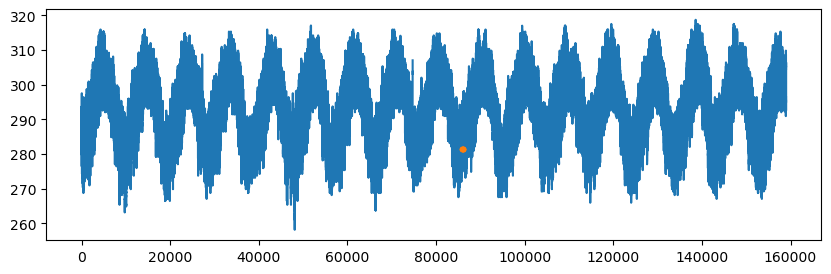

In [201]:
fig,ax = plt.subplots(figsize=(10,3))

df.tas.plot()
df[df['time'].isin(bad)].tas.plot(marker='.', lw=0)

In [202]:
# fig,ax = plt.subplots(figsize=(14,3))

# df.tas.plot()
# df[df['time'].isin(bad)].tas.plot(marker='.', lw=0)
# ax.set_xlim(pd.Timestamp('2015-01-15'), pd.Timestamp('2015-02-15'))
# # ax.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2014-03-01'))

(270.0, 300.0)

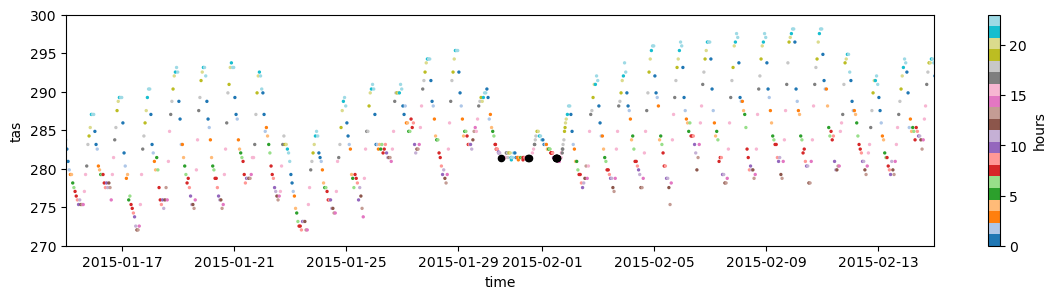

In [214]:
fig,ax = plt.subplots(figsize=(14,3))

df.plot.scatter("time", "tas", ax=ax, c='hours', cmap=mpl.cm.tab20, s=2)
# df[df['time'].isin(bad)].tas.plot(ax=ax, marker='o', mfc="none", lw=0, color="k")
df[df['time'].isin(bad)].plot.scatter("time", "tas", ax=ax, marker='o', color="k")
# ax.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2014-03-01'))
ax.set_xlim(pd.Timestamp('2015-01-15'), pd.Timestamp('2015-02-15'))
ax.set_ylim(270,300)

In [238]:
#---------------------------------------------------------------------------------------------------
def qaqc_unusual_repeated_streaks(df, plot=True, local=False, verbose=True, min_sequence_length=10):
    """
    Test for repeated streaks/unusual spell frequenc. 
    Three test are conducted here:
       - Consecutive observation replication
       - Same hour observation replication over a number of days 
         (either using a threshold of a certain number of observations, 
          or for sparser records, a number of days during which all the
          observations have the same value)
       - Whole day replication for a streak of days
    
    This test is done for ["tas", "tdps", "tdps_derived", "ps", "slp", "sfcWind"]
    
    Input:
    -----
        df [pandas dataframe] : station dataset converted to dataframe through QAQC pipeline
        local [bool] : if True, saves the plot to local directory
        plot [bool] : if True, produces plot and uploads it to AWS
    Output:
    ------
        if qaqc succeded:
            df [pandas dataframe] : QAQC dataframe with flagged values (see below for flag meaning).
        else if qaqc failed:
            None
    Flag meaninig:
    -------------
        27,qaqc_unusual_repeated_streaks,Same hour observation replication over a number of days
        28,qaqc_unusual_repeated_streaks,
        29,qaqc_unusual_repeated_streaks,

    NOTES:
    Threshold for different variables/resolutions are noted on: 
    https://doi.org/10.5194/cp-8-1649-2012 : Table 4
    
    TODO: 
    min_sequence_length can be tweaked, althought HadISD uses 10
    """

    # try:
    if True:
        
        # Infere resolution from data
        resolutions = infere_res(df)
        
        # Save original df multiindex and create station column
        df = df.copy(deep=True)

        # Define test variables and check if they are in the dataframe
        check_vars = ["tas", "tdps", "tdps_derived", "ps", "slp", "sfcWind"]
        # check_vars = ["ps"]
        variables = [var for var in check_vars if var in df.columns]
        
        if verbose:
            print("Running {} on {}".format("qaqc_unusual_repeated_streaks", variables))
        
        # Loop through test variables
        for var in variables:
            # Create a copy of the original dataframe and drop NaNs in the testing variable
            new_df = df.copy(deep=True)
            new_df = new_df.dropna(subset=var)#.drop(columns=["lat","lon","elevation"])
            
            # Use only values that have not been flagged by previous QAQC tests
            valid = np.where(np.isnan(new_df[var+"_eraqc"]))[0]
            new_df = new_df.iloc[valid]
            
            # Choose resolution
            res = resolutions[var]
            
            # --------------------------------------------------------
            # Hour repeat streak criteria
            threshold = hour_repeat_criteria[var][res]
            bad = hourly_repeats(new_df, var, threshold)            
            ind = df['time'].isin(bad)
            df.loc[ind, var+"_eraqc"] = 27    # Flag _eraqc variable
            
            # --------------------------------------------------------
            # Straight repeat streak criteria
            threshold = straight_repeat_criteria[var][res]
            if var=="sfcWind":
                wind_min_value = WIND_MIN_VALUE[res]
            else:
                wind_min_value = None
            bad = consecutive_repeats(new_df, var, threshold, 
                                      wind_min_value, 
                                      min_sequence_length=min_sequence_length)
            ind = df['time'].isin(bad)
            df.loc[ind, var+"_eraqc"] = 28    # Flag _eraqc variable
            
            # --------------------------------------------------------
            # Whole day replica- tion for a streak of days
            threshold = day_repeat_criteria[var][res]
            bad = consecutive_fullDay_repeats(new_df, var, threshold)
            ind = df['time'].isin(bad)
            df.loc[ind, var+"_eraqc"] = 29    # Flag _eraqc variable
            
            # --------------------------------------------------------
            # if plot:
            #     unusual_streaks_plot(df, var, flagval=22, local=local)
            #     for i in ind:
            #         subset = np.logical_and(df.index>=i - np.timedelta64(48,'h'), 
            #                             df.index<=i + np.timedelta64(48,'h'))
            #         unusual_jumps_plot(df[subset], var, flagval=22, date=i, local=local)
        return df
    # except Exception as e:
    #     print("qaqc_unusual_repeated_streaks failed with Exception: {}".format(e))
    #     return None

In [239]:
#---------------------------------------------------------------------------------------------------
# Find clusters of equal values
def select_streaks(x,y):
    """
    """
    if len(y)>0:
        return x[y]
    else:
        return []
    
#---------------------------------------------------------------------------------------------------
# Find clusters of equal values
def find_streaks_index(y, threshold=5):
    """
    """
    y = np.concatenate([y])
    y = y.astype("int")
    y[np.where(y==0)[0]] = 1
    split_indices = np.where(np.diff(y) != 0)[0] + 1
    clusters = np.split(y, split_indices)

    ind = [list(np.arange(split_indices[i-1], split_indices[i-1]+len(clusters[i]), 1)) 
           for i in range(1,len(clusters))]
    result = [i for i in ind if len(i)>threshold]
    
    if len(result)>0:
        return np.concatenate(result)
    else:
        return np.array([])
    
#---------------------------------------------------------------------------------------------------
def hourly_repeats(df, var, threshold):
    """
    Same hour observation replication over a number of days 
         (either using a threshold of a certain number of observations, 
          or for sparser records, a number of days during which all the
          observations have the same value):
          
    1 - Group variable by hour/value
    2 - Count consecutive cluster of repeated values at the same hour of the day
    3 - Select only clusters where count is higher than threshold in dict `hour_repeat_criteria`
    
    This test is done for ["tas", "tdps", "tdps_derived", "ps", "slp", "sfcWind"]
    
    Input:
    -----
        df [pandas dataframe] : station dataset converted to dataframe through QAQC pipeline
        var [str] : variable to test
        threshold [int] : comes from hour_repeat_criteria[var][res]
   Output:
    ------
        bad [numpy array] : dates that mark the flagged values (from df.index)
                  
    NOTES (TODO:)
    """

    # df['hours'] = pd.Series(df.index).dt.hour.values
    df['hours'] = pd.Series(df['time']).dt.hour.values
    # df['times'] = df.index.values
    # counts = pd.DataFrame(df.groupby(by=["hours",var]).apply(lambda x: np.array(x.index.tolist())).rename("dates"))
    counts = pd.DataFrame(df.groupby(by=["hours",var]).apply(lambda x: np.array(x['time'].tolist())).rename("dates"))
    counts['date_diff'] = counts['dates'].transform(lambda x: pd.Series(x).diff().values.astype("timedelta64[D]"))
    counts['streak_index'] = counts['date_diff'].apply(find_streaks_index, args=(7,))
    counts['streaks'] = counts.apply(lambda x: select_streaks(x.dates, x.streak_index), axis=1)
    
    bad = np.concatenate(counts['streaks'].values)
    return bad

In [240]:
#---------------------------------------------------------------------------------------------------
def consecutive_repeats(df, var, threshold, wind_min_value = None, 
                        min_sequence_length = 10):
    """
    Consecutive observation replication 
         (either using a threshold of a certain number of observations, 
          or for sparser records, a number of days during which all the
          observations have the same value):
          
    1 - 
    2 - 
    3 - 
    
    This test is done for ["tas", "tdps", "tdps_derived", "ps", "slp", "sfcWind"]
    
    Input:
    -----
        df [pandas dataframe] : station dataset converted to dataframe through QAQC pipeline
        var [str] : variable to test
        threshold (int,int) : comes from straight_repeat_criteria[var][res]
    Output:
    ------
        bad [numpy array] : dates that mark the flagged values (from df.index)
                  
    NOTES (TODO:)
    """

    da = df[[var,"time"]].copy()
    
    if var=="sfcWind": print(len(da))
    
    # If variable is wind, only use values above min wind value
    if wind_min_value is not None:
        print(wind_min_value)
        da = da[da[var]>wind_min_value]
    if var=="sfcWind": print(len(da))
    # Identify sequences of similar values
    da.loc[:, 'group'] = (da[var] != da[var].shift()).cumsum()
    # da.loc[:, 'start_date'] = da.index.values
    # da.loc[:, 'end_date'] = da.index.values
    da.loc[:, 'start_date'] = da['time'].values
    da.loc[:, 'end_date'] = da['time'].values
    
    start_date = da.copy().groupby([var, 'group']).min().sort_values(by="group").copy()
    end_date   = da.copy().groupby([var, 'group']).max().sort_values(by="group").copy()
    
    # Calculate the length of each sequence
    sequence_lengths = da.copy().groupby([var, 'group']).size().reset_index(name='sequence_length').sort_values(by="group")
    sequence_lengths.loc[:, 'start_date'] = start_date.loc[:, 'start_date'].values
    sequence_lengths.loc[:, 'end_date'] = end_date.loc[:, 'end_date'].values
    
    # Filter sequences with a minimum length
    min_sequence_length = 10
    filtered_sequences = sequence_lengths.copy()[sequence_lengths.loc[:, 'sequence_length'] >= min_sequence_length]
    filtered_sequences.loc[:, 'dt'] = (filtered_sequences.loc[:, 'end_date'] -
                                filtered_sequences.loc[:, 'start_date']).values.astype("timedelta64[D]")
    
    # Get limits
    nvalues, ndays = threshold
    
    #TODO: fix this commented line, 2x sequence_length to test, it should be dt
    condition = np.logical_or(filtered_sequences.loc[:, 'sequence_length'] > nvalues,
                              filtered_sequences['dt'].astype("int") > ndays)
    
    # Find bad groups and index in the original dataset
    bad_groups = filtered_sequences[condition].group.values
    bad = da[da['group'].isin(bad_groups)]['time'].values

    return bad

In [256]:
#---------------------------------------------------------------------------------------------------
def consecutive_fullDay_repeats(df, var, threshold):
    """
    Consecutive observation replication 
         (either using a threshold of a certain number of observations, 
          or for sparser records, a number of days during which all the
          observations have the same value):
          
    1 - 
    2 - 
    3 - 
    
    This test is done for ["tas", "tdps", "tdps_derived", "ps", "slp", "sfcWind"]
    
    Input:
    -----
        df [pandas dataframe] : station dataset converted to dataframe through QAQC pipeline
        var [str] : variable to test
        threshold (int,int) : comes from straight_repeat_criteria[var][res]
    Output:
    ------
        bad [numpy array] : dates that mark the flagged values (from df.index)
                  
    NOTES (TODO:)
    """

    da = df[[var, 'time']].copy()
    # da['date'] = pd.Series(da.index).dt.date.values
    da['date'] = pd.Series(da['time']).dt.date.values

    whole_days = da.groupby(by=['date'])[var].apply(lambda x: " ".join(map(str, np.array(np.round(x.values, decimals=1)))))
    whole_days = pd.DataFrame({var:whole_days, 'date':whole_days.index.values}) 
    
    # TODO: Please comment or delete this line, just for testing
    whole_days.loc[:, 'group'] = (whole_days[var] != whole_days[var].shift()).cumsum()

    # Calculate the length of each sequence
    sequence_lengths = whole_days.copy().groupby([var, 'group']).size().reset_index(name='sequence_length').sort_values(by="group")

    # Filter sequences with a minimum length
    filtered_sequences = sequence_lengths.copy()[sequence_lengths.loc[:, 'sequence_length'] >= threshold]

    bad_groups = filtered_sequences.group
    bad_dates = whole_days[whole_days['group'].isin(bad_groups)]['date']

    # bad = da[da['date'].isin(bad_dates)].index.values
    bad = da[da['date'].isin(bad_dates)]['time'].values

    return bad

In [245]:
ds = xr.open_dataset('train_files/RAWS_ZMBA2.nc').isel(station=0)
ds = xr.open_dataset('train_files/RAWS_PKLC2.nc').isel(station=0)
ds = xr.open_dataset('train_files/ASOSAWOS_72274793084.nc')
df = xarray_to_pandas_qaqc(ds)
df = qaqc_world_record(df)
df['tas'].iloc[11001:11035] = df['tas'].iloc[11000]

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")
/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_18373/1557074058.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tas'].iloc[11001:11035] = df['tas'].iloc[11000]


In [246]:
threshold = straight_repeat_criteria['tas'][0.5]
bad = consecutive_repeats(df, 'tas', threshold)
ind = df['time'].isin(bad)
ind.any()

True

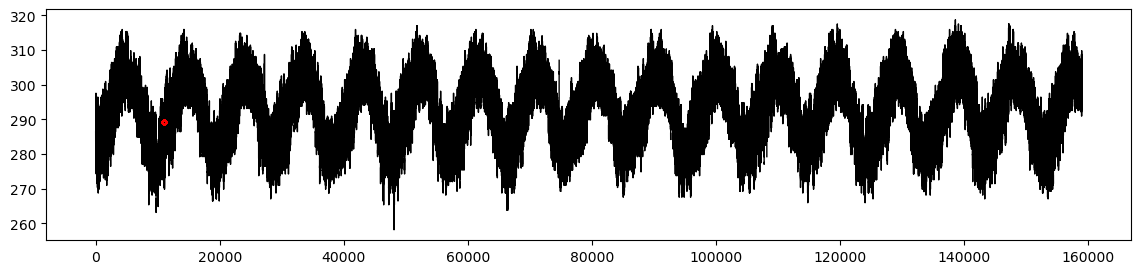

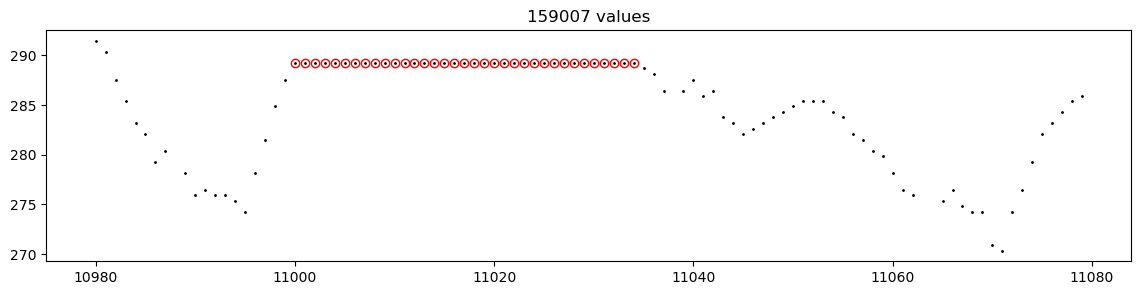

In [247]:
fig,ax = plt.subplots(figsize=(14,3))
df.tas.plot(ax=ax, c="k", lw=1)
# df.tas[ind].plot(ax=ax, marker='o', lw=0, mfc='none', color="red")
df.tas[ind].plot(ax=ax, marker='.', lw=0, mfc='none', color="red")

fig,ax = plt.subplots(figsize=(14,3))
df.iloc[10980:11080].tas.plot(ax=ax, c="k", lw=0, marker=".", ms=2)
df.loc[ind, 'tas'].plot(ax=ax, marker='o', lw=0, mfc='none', color="red")
_ = ax.set_title("{} values".format(len(ind)))

In [262]:
ds = xr.open_dataset('train_files/RAWS_ZMBA2.nc').isel(station=0)
ds = xr.open_dataset('train_files/RAWS_PKLC2.nc').isel(station=0)
ds = xr.open_dataset('train_files/ASOSAWOS_72274793084.nc')
df = xarray_to_pandas_qaqc(ds)
df = qaqc_world_record(df)

df['tas'].iloc[11001:11400] = df['tas'].iloc[11000]

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")
/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_18373/1131924466.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tas'].iloc[11001:11400] = df['tas'].iloc[11000]


In [263]:
threshold = day_repeat_criteria['tas'][0.5]
bad = consecutive_fullDay_repeats(df, 'tas', threshold)
print(len(bad))
ind = df['time'].isin(bad)

300


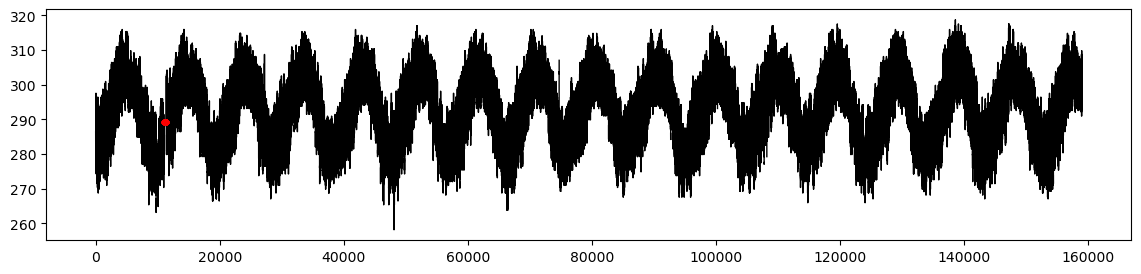

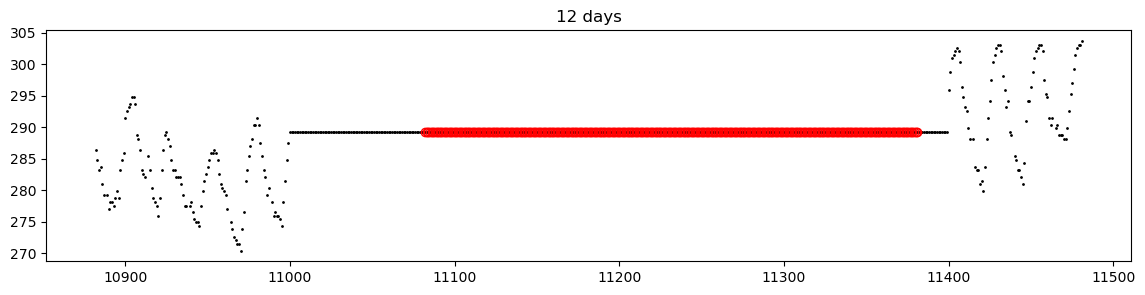

In [270]:
fig,ax = plt.subplots(figsize=(14,3))
df.tas.plot(ax=ax, c="k", lw=1)
# df.tas[bad].plot(ax=ax, marker='o', lw=0, mfc='none', color="red")
df.tas.loc[ind].plot(ax=ax, marker='.', lw=0, mfc='none', color="red")

fig,ax = plt.subplots(figsize=(14,3))
df.tas.loc[min(np.where(ind)[0])-200:max(np.where(ind)[0])+100].plot(ax=ax, c="k", lw=0, marker=".", ms=2)
df.loc[ind].tas.plot(ax=ax, marker='o', lw=0, mfc='none', color="red")
# ax.set_xlim(np.datetime64("2007-02-22"), np.datetime64("2007-03-18"))
_ = ax.set_title("{} days".format(len(bad)//24))

In [273]:
ds = xr.open_dataset('train_files/RAWS_ZMBA2.nc').isel(station=0)
ds = xr.open_dataset('train_files/RAWS_PKLC2.nc').isel(station=0)
ds = xr.open_dataset('train_files/ASOSAWOS_72274793084.nc')
df = xarray_to_pandas_qaqc(ds)
df = qaqc_world_record(df)
df = df.copy()
# df['hours'] = pd.Series(df.index).dt.hour.values
# df['day'] = pd.Series(df.index).dt.day.values
# df['month'] = pd.Series(df.index).dt.month.values
# df['year'] = pd.Series(df.index).dt.year.values
df['hours'] = pd.Series(df['time']).dt.hour.values
df['day'] = pd.Series(df['time']).dt.day.values
df['month'] = pd.Series(df['time']).dt.month.values
df['year'] = pd.Series(df['time']).dt.year.values
condition = np.logical_and(df['hours']==12, np.logical_and(df['month']>2, df['month']<4))
condition = np.logical_and(df['year']==2006, condition)
condition = df[condition].index.values
df.loc[condition, 'tas'] = 300.
len(condition)

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


32

In [46]:
# df[df['hours']==12].tas.iloc[500:590] = 300.
# df[df['hours']==12].tas.iloc[500:590]
# df[condition].tas

In [275]:
threshold = hour_repeat_criteria['tas'][0.5]
print(threshold)
bad = hourly_repeats(df, 'tas', threshold)
print(len(bad))
ind = df['time'].isin(bad)

20
37


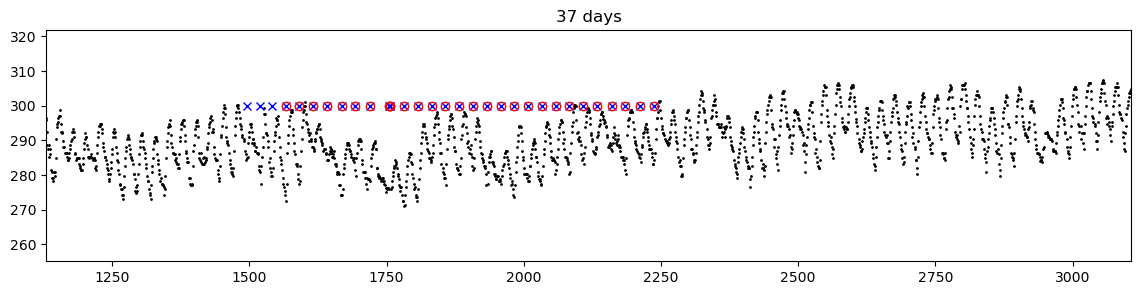

In [281]:
fig,ax = plt.subplots(figsize=(14,3))
df.tas.plot(ax=ax, c="k", lw=0, marker=".", ms=2)
df.loc[condition].tas.plot(ax=ax, marker='x', lw=0, mfc='none', color="blue")
df.loc[ind].tas.plot(ax=ax, marker='o', lw=0, mfc='none', color="red")
x0 = np.where(df['time']<=np.datetime64("2006-02-15"))[0][-1]
x1 = np.where(df['time']<=np.datetime64("2006-05-05"))[0][-1]+1
ax.set_xlim(x0,x1)
_ = ax.set_title("{} days".format(len(bad)))

In [282]:
#---------------------------------------------------------------------------------------------------
def unusual_streaks_plot(df, var, flagvals=(27,28,29), dpi=None, local=False, date=None):
    """
    Plots unusual large jumps qaqc result and uploads it to AWS (if local, also writes to local folder)
    Input:
    -----
        df [pd.Dataframe] : station pd.DataFrame from qaqc pipeline
        var [str] : variable name
        flagval [int] : flag value to plot (22 for unusual large jumps)
        dpi [int] : resolution for png plots
        local [bool] : if True, saves plot locally, else: only saves plot to AWS
    Ouput:
    ----- 
        None
    """
    
    # grab flagged data
    flag_vals_0 = df.loc[df[var + '_eraqc'] == flagvals[0]]   
    flag_vals_1 = df.loc[df[var + '_eraqc'] == flagvals[1]]   
    flag_vals_2 = df.loc[df[var + '_eraqc'] == flagvals[2]]   
    
    # Create figure
    if date is not None:
        fig,ax = plt.subplots(figsize=(7,3))
    else:
        fig,ax = plt.subplots(figsize=(10,3))

    # Plot variable and flagged data
    df[var].plot(ax=ax, marker=".", ms=4, lw=1, color="k", alpha=0.5, label="Original data")
    
    # Amount of data flagged
    nflags = len(flag_vals_0) + len(flag_vals_1) + len(flag_vals_2)
    title = "{:.4f}% of data flagged".format(100*nflags/len(df))
    flag_label_0 = "Same hour replication"
    flag_label_1 = "Consecutive replication"
    flag_label_2 = "Whole-day replication"
    df.loc[df[var+"_eraqc"]==flagvals[0], var].plot(ax=ax, marker="s", ms=7, lw=0, mfc="none", color="C3", label=flag_label_0)    
    df.loc[df[var+"_eraqc"]==flagvals[1], var].plot(ax=ax, marker="x", ms=7, lw=0, mfc="none", color="C4", label=flag_label_1)    
    df.loc[df[var+"_eraqc"]==flagvals[2], var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C4", label=flag_label_2)    
    legend = ax.legend(loc=0, prop={'size': 8})    
    title = ax.set_title(title)    
        
#     station = df['station'].unique()[0]
#     network = station.split('_')[0]
    
#     # Plot aesthetics
#     ylab, units, miny, maxy = _plot_format_helper_spikes(var)
#     ylab = '{} [{}]'.format(ylab, units)
    
#     ax.set_ylabel(ylab)
#     ax.set_xlabel('')
    
#     # We can set ylim since this function is supposed to be run after other QAQC functions (including world records)
#     if date is not None:
#         timestamp = str(date).split(":")[0].replace(" ","T")
#     else:
#         timestamp = "full_series"
#         miny = max(miny, df[var].min())
#         maxy = min(maxy, df[var].max())
#         ax.set_ylim(miny,maxy)
    
#     title = 'Unusual large jumps check: {0}'.format(station)
#     ax.set_title(title, fontsize=10)
    
#     # save to AWS
#     bucket_name = 'wecc-historical-wx'
#     directory = '3_qaqc_wx'
#     figname = 'qaqc_figs/qaqc_unusual_large_jumps_{0}_{1}_{2}'.format(station, var, timestamp)
#     key = '{0}/{1}/{2}.png'.format(directory, network, figname)
#     img_data = BytesIO()
#     fig.savefig(img_data, format='png', dpi=dpi, bbox_inches="tight")
#     img_data.seek(0)
#     s3 = boto3.resource('s3')
#     bucket = s3.Bucket(bucket_name)
#     bucket.put_object(Body=img_data, ContentType='image/png', Key=key)
#     plt.close()
#     if local:
#         fig.savefig(figname+".png", format='png', dpi=dpi, bbox_inches="tight")
    
    return 

In [285]:
ds = xr.open_dataset('train_files/RAWS_ZMBA2.nc').isel(station=0)
ds = xr.open_dataset('train_files/RAWS_PKLC2.nc').isel(station=0)
ds = xr.open_dataset('train_files/ASOSAWOS_72274793084.nc')
df = xarray_to_pandas_qaqc(ds)
df = qaqc_world_record(df)
df['tas'].iloc[11001:11035] = df['tas'].iloc[11000]
df['tas'].iloc[21001:21400] = df['tas'].iloc[21000]
# df['hours'] = pd.Series(df.index).dt.hour.values
# df['day'] = pd.Series(df.index).dt.day.values
# df['month'] = pd.Series(df.index).dt.month.values
# df['year'] = pd.Series(df.index).dt.year.values
df['hours'] = pd.Series(df['time']).dt.hour.values
df['day'] = pd.Series(df['time']).dt.day.values
df['month'] = pd.Series(df['time']).dt.month.values
df['year'] = pd.Series(df['time']).dt.year.values
condition = np.logical_and(df['hours']==12, np.logical_and(df['month']>2, df['month']<4))
condition = np.logical_and(df['year']==2010, condition)
condition = df[condition].index.values
df.loc[condition, 'tas'] = 300.

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")
/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_18373/3679077418.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tas'].iloc[11001:11035] = df['tas'].iloc[11000]
/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_18373/3679077418.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

In [286]:
newdf = qaqc_unusual_repeated_streaks(df, plot=False, local=False, verbose=True, min_sequence_length=10)

Running qaqc_unusual_repeated_streaks on ['tas', 'tdps', 'ps', 'sfcWind']
151621
0.5
131540


In [287]:
(
  newdf['tas_eraqc'].dropna().any(),
  newdf['tdps_eraqc'].dropna().any(),
  newdf['sfcWind_eraqc'].dropna().any(),
  newdf['ps_eraqc'].dropna().any(),
)

(True, False, True, False)

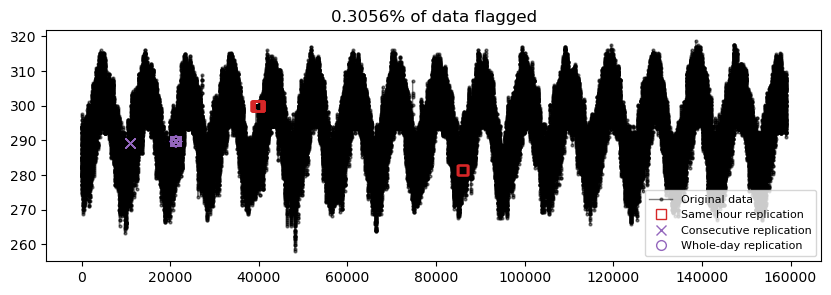

In [288]:
var = "tas"
unusual_streaks_plot(newdf, var, flagvals=(27,28,29), dpi=None, local=False, date=None)

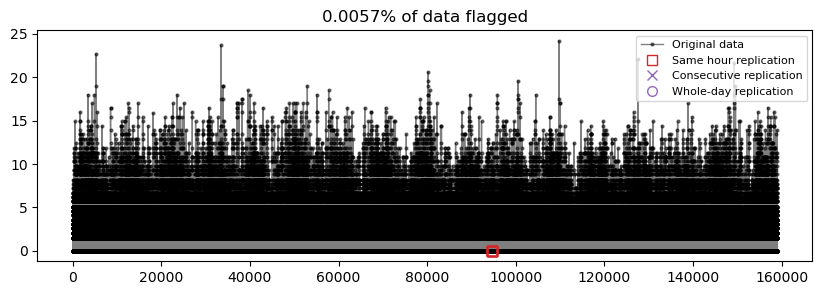

In [289]:
var = "sfcWind"
unusual_streaks_plot(newdf, var, flagvals=(27,28,29), dpi=None, local=False, date=None)

In [291]:
ind = newdf['sfcWind_eraqc']==27
newdf[ind][['time','sfcWind']]

time  sfcWind
94655 2015-12-23 15:07:00      0.0
94656 2015-12-23 15:51:00      0.0
94702 2015-12-24 15:10:00      0.0
94703 2015-12-24 15:13:00      0.0
94704 2015-12-24 15:20:00      0.0
94705 2015-12-24 15:32:00      0.0
94706 2015-12-24 15:51:00      0.0
94737 2015-12-25 15:43:00      0.0
94738 2015-12-25 15:49:00      0.0

# OLD

## ML to fit annual cycle

<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">We need to remove the seasonal signal from the data to be able to look for unusual spikes in the data.</p></span> 
</div>
<br>
<img src="https://raw.githubusercontent.com/indahector/notebook_plots/main/Seasonal.png" width="500" height="500">
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">One way would be to fit annual and seasonal harmonic and remove it from the original series.</p></span> 
</div>

In [2]:
from sklearn.linear_model import SGDRegressor
from sklearn.utils.fixes import parse_version, sp_version
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn import base

class FourierComponents(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, freq):
        self.freq = freq
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).values.astype("float")/1e9
        dt = dt * 2 * np.pi * self.freq
        return np.c_[np.sin(dt), np.cos(dt)]

f_d = 1/(3600)
f_s = 1/(365*24*4*3600)
f_y = 1/(365*24*3600)

union = FeatureUnion([
                      ('fourier_annual', FourierComponents(f_y)),
                      ('fourier_seasonal', FourierComponents(f_s)),
                      # ('fourier_daily', FourierComponents(f_d)),
                    ])
model_drift_fourier = Pipeline([('union', union),
                                ('regressor', LinearRegression())])

class FullModel(base.BaseEstimator, base.RegressorMixin):
    def __init__(self):
        """Combine a baseline and residual model to predict any number of steps in the future."""
        
        self.baseline = model_drift_fourier
        self.residual_model = LinearRegression()
        
    def fit(self, X, y):
        self.baseline.fit(X.index, X[var])
        resd = X[var] - self.baseline.predict(X.index)
        self.residual_model.fit(X.index.values.astype("float").reshape(-1,1), resd) 
        # self.residual_model.fit(X.index, resd) 
        return self
    
    def predict(self, X):
        y_b = self.baseline.predict(X.index)
        y_r = self.residual_model.predict(X.index.values.astype("float").reshape(-1,1),)
        plt.plot(y_r)
        y_pred = y_b + y_r
        
        return y_pred

class ResidualFeatures(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, window=20):
        """Generate features based on window statistics of past noise/residuals."""
        self.window = window
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = pd.DataFrame()
        df['residual'] = pd.Series(X, index=X.index)
        df['prior'] = df['residual'].shift(1)
        df['mean'] = df['residual'].rolling(window=self.window, min_periods=0).mean()
        df['diff'] = df['residual'].diff().rolling(window=self.window).mean()
        df = df.fillna(method='bfill')
        return df

In [3]:
ds = xr.open_dataset('train_files/SNOTEL_835.nc').isel(station=0)
ds

<xarray.Dataset>
Dimensions:    (time: 149896)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01T08:00:00 ... 2022-08-31T23:00:00
    station    <U10 'SNOTEL_835'
    lat        (time) float64 ...
    lon        (time) float64 ...
Data variables:
    tas        (time) float64 ...
    pr         (time) float64 ...
    tas_qc     (time) object ...
    pr_qc      (time) object ...
    elevation  (time) float64 ...
Attributes: (12/17)
    title:                 SNOTEL cleaned
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               SCANSNOTEL_clean.py script run on 02-16-2023, 23:3...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    station_name:          Twelvemile Creek
    subnetwork:            SNOTEL
    huc:                   170102050601
    hud:                   17010205
    shefId:                TMCM8
    raw_files_merged:      1

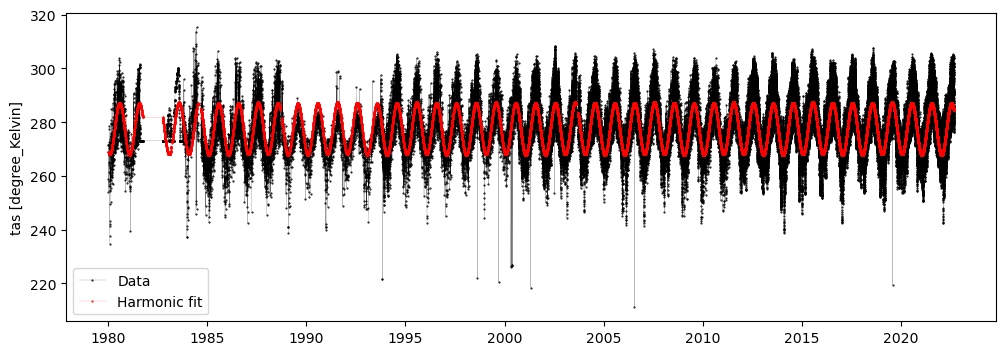

In [4]:
var = 'tas'
# var = 'hurs'
df = ds[var].to_dataframe().dropna(subset=var).drop(columns=["lat","lon"])#.reset_index()

model = model_drift_fourier
model.fit(df.index, df[var])
y_base = model.predict(df.index)

DAYS_INTO_FUTURE = 3
train_noise = df[var]-y_base

# create and train residual model
residual_model = Pipeline([('residual_features', ResidualFeatures(window=10)), 
                           ('regressor', SGDRegressor())])
residual_model.fit(train_noise.iloc[:-DAYS_INTO_FUTURE], 
                   train_noise.shift(-DAYS_INTO_FUTURE).dropna())

y_res = residual_model.predict(train_noise)

y_fit = y_base + y_res*0.

fig,ax = plt.subplots(figsize=(12,4))
ax.plot(df.index, df[var], '.-', lw=0.1, ms=1, color="k", label="Data")
ax.plot(df.index, y_fit, '.-', lw=0.1, ms=1, color="r", label="Harmonic fit")
# ax.set_title("{:.4f}".format(len(np.where(ind)[0])/len(df.index)))
ax.legend()
ax.set_ylabel("{} [{}]".format(var, ds[var].attrs['units']))
df['y_fit'] = y_fit

## HadISD method

<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">To be consistent with HadISD methodology, we will avoid the harmonic fitting. Instead, we do an analysis per month in the data, this way we avoid seasonal signal from strongly seasonal stations.</p></span> 
</div>
<br>
<img src="https://raw.githubusercontent.com/indahector/notebook_plots/main/HadISD1.png" width="500" height="500">
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">First, we divide the data into months, and calculate the time difference between data. We limit this to data separated by less than 10 hours.</p></span> 
</div>
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">Then, we calculate the differences in the time series, which is the variable to work with.</p></span> 
</div>
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">The critical value to select potential spikes is 6 times the IQR of that month's differences.</p></span> 
</div>


### SNOTEL_835

In [5]:
ds = xr.open_dataset('train_files/SNOTEL_835.nc').isel(station=0)
ds

<xarray.Dataset>
Dimensions:    (time: 149896)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01T08:00:00 ... 2022-08-31T23:00:00
    station    <U10 'SNOTEL_835'
    lat        (time) float64 ...
    lon        (time) float64 ...
Data variables:
    tas        (time) float64 ...
    pr         (time) float64 ...
    tas_qc     (time) object ...
    pr_qc      (time) object ...
    elevation  (time) float64 ...
Attributes: (12/17)
    title:                 SNOTEL cleaned
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               SCANSNOTEL_clean.py script run on 02-16-2023, 23:3...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    station_name:          Twelvemile Creek
    subnetwork:            SNOTEL
    huc:                   170102050601
    hud:                   17010205
    shefId:                TMCM8
    raw_files_merged:      1

In [6]:
df = ds[var].to_dataframe().dropna(subset=var).drop(columns=["lat","lon"])#.reset_index()

In [7]:
# df['abs_difference'] = np.abs(df[var].diff().fillna(0))
df['difference'] = df[var].diff().fillna(0)
# df['difference'] = (df[var]-df['y_fit']).diff().fillna(0)
df['date'] = df.index.values
df['time_diff'] = df['date'].diff().fillna(pd.Timedelta(0))
df['hours_diff'] = df['time_diff']/np.timedelta64(1, 'h')
dfbk = df.copy(deep=True)
df = df[np.logical_and(df['hours_diff'] >= 1, df['hours_diff'] <= 12)]
df

station         tas  difference                date  \
time                                                                          
1980-01-04 22:00:00  SNOTEL_835  271.650000   12.888889 1980-01-04 22:00:00   
1980-01-17 21:00:00  SNOTEL_835  270.372222   -1.500000 1980-01-17 21:00:00   
1980-01-18 21:00:00  SNOTEL_835  264.650000    0.500000 1980-01-18 21:00:00   
1980-01-21 21:00:00  SNOTEL_835  272.427778    4.500000 1980-01-21 21:00:00   
1980-01-24 22:00:00  SNOTEL_835  278.372222    1.000000 1980-01-24 22:00:00   
...                         ...         ...         ...                 ...   
2022-08-31 19:00:00  SNOTEL_835  303.927778    2.500000 2022-08-31 19:00:00   
2022-08-31 20:00:00  SNOTEL_835  303.872222   -0.055556 2022-08-31 20:00:00   
2022-08-31 21:00:00  SNOTEL_835  304.538889    0.666667 2022-08-31 21:00:00   
2022-08-31 22:00:00  SNOTEL_835  303.927778   -0.611111 2022-08-31 22:00:00   
2022-08-31 23:00:00  SNOTEL_835  302.150000   -1.777778 2022-08-31 23:00:00   

                          time_diff  hours_diff  
time                                             
1980-01-04 22:00:00 0 days 10:00:00        10.0  
1980-01-17 21:00:00 0 days 09:00:00         9.0  
1980-01-18 21:00:00 0 days 09:00:00         9.0  
1980-01-21 21:00:00 0 days 07:00:00         7.0  
1980-01-24 22:00:00 0 days 07:00:00         7.0  
...                             ...         ...  
2022-08-31 19:00:00 0 days 01:00:00         1.0  
2022-08-31 20:00:00 0 days 01:00:00         1.0  
2022-08-31 21:00:00 0 days 01:00:00         1.0  
2022-08-31 22:00:00 0 days 01:00:00         1.0  
2022-08-31 23:00:00 0 days 01:00:00         1.0  

[139439 rows x 6 columns]

Text(0, 0.5, 'tas [degree_Kelvin]')

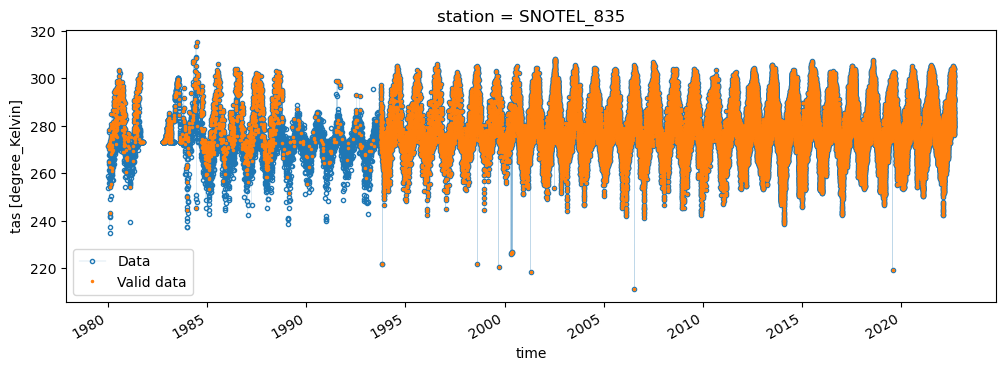

In [8]:
fig,ax = plt.subplots(figsize=(12,4))

ds[var].plot(ax=ax, marker=".", ms=6, lw=.1, mfc='none', label="Data")
df[var].plot(ax=ax, marker=".", ms=3, lw=0, label="Valid data")
ax.legend()
ax.set_ylabel("{} [{}]".format(var, ds[var].attrs['units']))

Text(0, 0.5, 'tas [degree_Kelvin]')

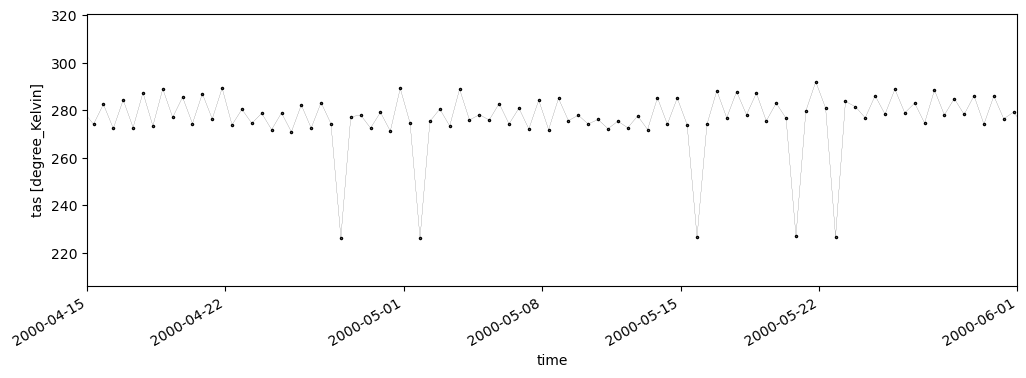

In [9]:
fig,ax = plt.subplots(figsize=(12,4))

(df[var]).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
ax.set_xlim(np.datetime64("2000-04-15"), np.datetime64("2000-06-01"))
ax.set_ylabel("{} [{}]".format(var, ds[var].attrs['units']))

In [10]:
# grouped = df.groupby([pd.Grouper(freq='M'), df['hours_diff']]) 
grouped = df.groupby(pd.Grouper(freq='M')) 

# grouped = df.groupby([pd.Grouper(freq='Y'), df['hours_diff']]) 
# grouped = df.groupby([pd.Grouper(freq='Y')]) 
# grouped = df.groupby([df['hours_diff']]) 

counts = grouped['difference'].transform("count")

# std = grouped['difference'].transform("median") + grouped['difference'].transform("std")

df['counts'] = counts
df = df[df['counts']>100]

# kwargs = {'rng':(15, 85),
# kwargs = {'rng':(25, 75),
#           'scale':1.0,
#           'nan_policy':'propagate',
#           'interpolation':'linear',
#          }
# kwargs = {'rng':(20, 80),}
kwargs = {}
iqr = grouped['difference'].transform(scipy.stats.iqr, **kwargs)
# abs_iqr = grouped['abs_difference'].transform(scipy.stats.iqr, **kwargs)
df['iqr'] = iqr
# df['abs_iqr'] = abs_iqr
# df['std'] = std

df['critical'] = np.ceil(6*df['iqr'])
# df['abs_critical'] = np.ceil(6*df['abs_iqr'])
df

# df.iloc[-16800:-16750]

/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_17397/11751727.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iqr'] = iqr
/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_17397/11751727.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['critical'] = np.ceil(6*df['iqr'])


station         tas  difference                date  \
time                                                                          
1993-10-01 08:00:00  SNOTEL_835  276.872222   -9.277778 1993-10-01 08:00:00   
1993-10-01 11:00:00  SNOTEL_835  275.261111   -1.611111 1993-10-01 11:00:00   
1993-10-01 14:00:00  SNOTEL_835  274.761111   -0.500000 1993-10-01 14:00:00   
1993-10-01 17:00:00  SNOTEL_835  286.038889   11.277778 1993-10-01 17:00:00   
1993-10-01 20:00:00  SNOTEL_835  287.761111    1.722222 1993-10-01 20:00:00   
...                         ...         ...         ...                 ...   
2022-08-31 19:00:00  SNOTEL_835  303.927778    2.500000 2022-08-31 19:00:00   
2022-08-31 20:00:00  SNOTEL_835  303.872222   -0.055556 2022-08-31 20:00:00   
2022-08-31 21:00:00  SNOTEL_835  304.538889    0.666667 2022-08-31 21:00:00   
2022-08-31 22:00:00  SNOTEL_835  303.927778   -0.611111 2022-08-31 22:00:00   
2022-08-31 23:00:00  SNOTEL_835  302.150000   -1.777778 2022-08-31 23:00:00   

                          time_diff  hours_diff  counts       iqr  critical  
time                                                                         
1993-10-01 08:00:00 0 days 06:00:00         6.0     227  3.444444      21.0  
1993-10-01 11:00:00 0 days 03:00:00         3.0     227  3.444444      21.0  
1993-10-01 14:00:00 0 days 03:00:00         3.0     227  3.444444      21.0  
1993-10-01 17:00:00 0 days 03:00:00         3.0     227  3.444444      21.0  
1993-10-01 20:00:00 0 days 03:00:00         3.0     227  3.444444      21.0  
...                             ...         ...     ...       ...       ...  
2022-08-31 19:00:00 0 days 01:00:00         1.0     742  2.055556      13.0  
2022-08-31 20:00:00 0 days 01:00:00         1.0     742  2.055556      13.0  
2022-08-31 21:00:00 0 days 01:00:00         1.0     742  2.055556      13.0  
2022-08-31 22:00:00 0 days 01:00:00         1.0     742  2.055556      13.0  
2022-08-31 23:00:00 0 days 01:00:00         1.0     742  2.055556      13.0  

[133305 rows x 9 columns]

In [11]:
df['potential_spike'] = np.abs(df['difference'])>df['critical']
len(np.where(df['potential_spike'])[0])

/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_17397/3457975501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['potential_spike'] = np.abs(df['difference'])>df['critical']


422

<AxesSubplot:xlabel='time'>

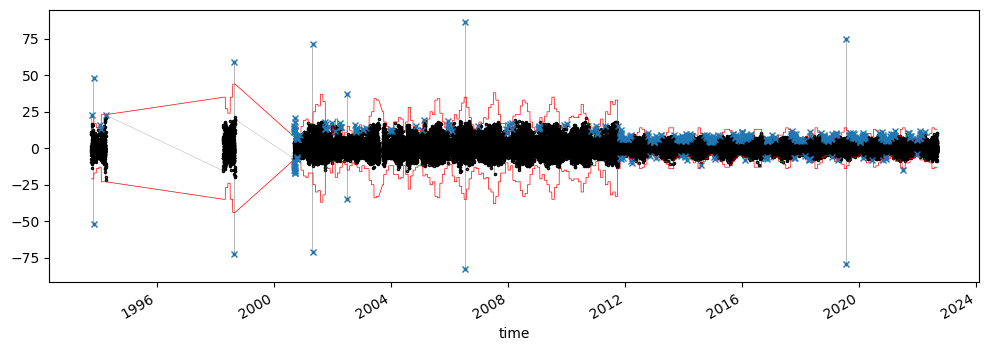

In [12]:
fig,ax = plt.subplots(figsize=(12,4))

(df['difference']).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
(df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
(-1*df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")

# fig,ax = plt.subplots(figsize=(12,4))

# (df['abs_difference']).plot(ax=ax, marker=".", ms=2, lw=.1, mfc='none', color="k")
# (df['abs_critical']).plot(ax=ax, lw=.5, color="red")

<AxesSubplot:xlabel='time'>

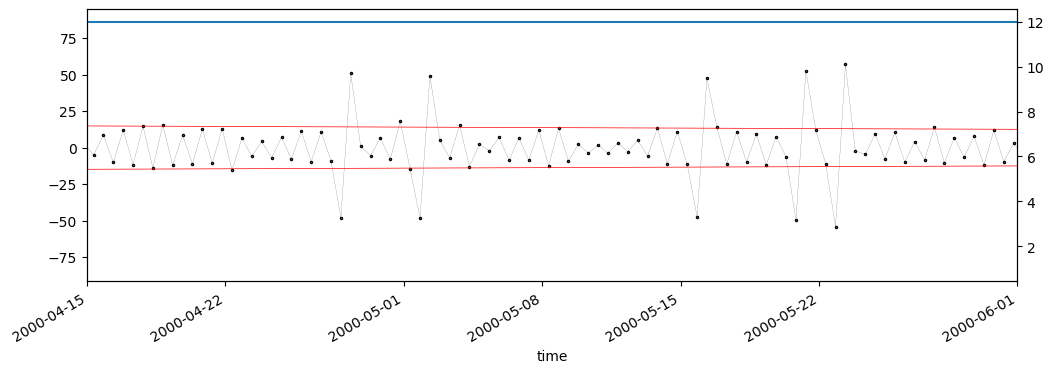

In [13]:
fig,ax = plt.subplots(figsize=(12,4))

(dfbk['difference']).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
(df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
(-1*df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
ax.set_xlim(np.datetime64("2000-04-15"), np.datetime64("2000-06-01"))
axt = ax.twinx()
df['hours_diff'].plot(ax=axt)

<AxesSubplot:xlabel='time'>

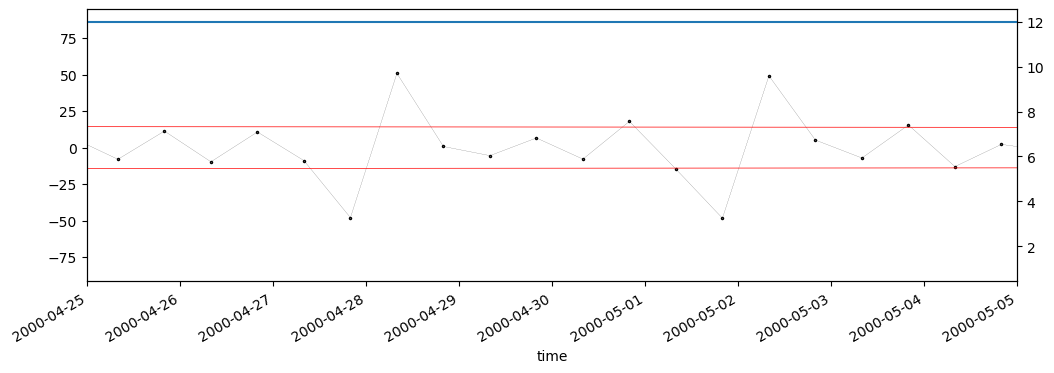

In [14]:
fig,ax = plt.subplots(figsize=(12,4))

(dfbk['difference']).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
(df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
(-1*df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
ax.set_xlim(np.datetime64("2000-04-25"), np.datetime64("2000-05-05"))
axt = ax.twinx()
df['hours_diff'].plot(ax=axt)

In [15]:
def potential_spike_check(potential_spike, diff, crit, hours_diff):
    """
    data is `potential_spike`
    """

    potential_spike = potential_spike.copy(deep=True)
    
    ind = np.where(potential_spike)[0]
    spikes = pd.Series(np.zeros_like(potential_spike).astype("bool"), index=potential_spike.index)
    dates = pd.Series(potential_spike.index.values)
    # print(len(ind))
    # print(dates[ind])
    
    for i in ind:
        
        #Ignore edges for now
        if i==1 or i>=len(potential_spike)-4:
            continue
        # Indices, critical values, and values before and after potential spike
        im1, i0, ip1, ip2, ip3, ip4 = [i-1, i, i+1, i+2, i+3, i+4]
        tm1, t0, tp1, tp2, tp3, tp4 = diff.iloc[[im1, i0, ip1, ip2, ip3, ip4]]
        cm1, c0, cp1, cp2, cp3, cp4 = crit.iloc[[im1, i0, ip1, ip2, ip3, ip4]]
        # print(dates.iloc[[i0,ip1]])
        # print(" sgn(t0)[{}] != sgn(tm1)[{}] \n abs(tm1)[{}] < cm1[{}] \n abs(tp1)[{}] > cp1[{}] \n abs(tp2)[{}] < cp2[{}]".format(np.sign(t0),np.sign(tp1), np.abs(tm1), cm1, np.abs(tp1), cp1, np.abs(tp2), cp2))
        # print()
        # Three-values spike
        if (
            np.sign(t0) != np.sign(tp2) and 
            np.abs(tm1) < 0.5*cm1 and 
            np.abs(tp1) < 0.5*cp1 and 
            np.abs(tp2) < 0.5*cp2 and 
            np.abs(tp3) > cp3 and 
            np.abs(tp4) < 0.5*cp4
        ):
            # print(dates.iloc[i0])
            spikes.iloc[[i0,ip1,ip2]] = True
            # i += 3
            # continue
            
        # Two-values spike
        elif (
            np.sign(t0) != np.sign(tp2) and 
            np.abs(tm1) < 0.5*cm1 and 
            np.abs(tp1) < 0.5*cp1 and 
            np.abs(tp2) > cp2 and 
            np.abs(tp3) < 0.5*cp3
        ):
            # print(dates.iloc[i0])
            spikes.iloc[[i0,ip1]] = True
            # i += 2
            # continue
        
        # One-value spike
        elif( 
            np.sign(t0) != np.sign(tp1) and 
            np.abs(tm1) < 1.0*cm1 and 
            np.abs(tp1) > cp1 and 
            np.abs(tp2) < 1.0*cp2
        ):
            # print(dates.iloc[i0])
            spikes.iloc[i0] = True
            # i += 1
            # continue
        
    return spikes

<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">The nexts step is to take all potential spikes, and determine which are real spikes. For this, we only account for one, two, and three value-spikes.</p></span> 
</div>
<br>
<img src="https://raw.githubusercontent.com/indahector/notebook_plots/main/HadISD2.png" width="500" height="500">
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">The difference before the spike must be less than half the critical value.</p></span> 
</div>
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">The spike itself must be higher than the critical difference value.</p></span> 
</div>
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">Differences within the multi-value-spike must be less than half the critical value.</p></span> 
</div>
<div style="display: flex;">
    <span style="width: 59%"><p size="+2.75">Finally, the spike exit: The difference after the spike must be of the opposite sign of the actual spike, and be higher in magnitude than the critical value.</p></span> 
</div>

Assuming only up to 3 values spikes are accounted for her, I assume larger spikes should be detected by the distribution (an other) QAQC functions? 

In [16]:
spikes = potential_spike_check(df['potential_spike'], df['difference'], df['critical'], df['hours_diff'])
print(len(np.where(spikes)[0]))
df['spikes'] = spikes
df.head(5)

11


/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_17397/580060253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spikes'] = spikes


station         tas  difference                date  \
time                                                                          
1993-10-01 08:00:00  SNOTEL_835  276.872222   -9.277778 1993-10-01 08:00:00   
1993-10-01 11:00:00  SNOTEL_835  275.261111   -1.611111 1993-10-01 11:00:00   
1993-10-01 14:00:00  SNOTEL_835  274.761111   -0.500000 1993-10-01 14:00:00   
1993-10-01 17:00:00  SNOTEL_835  286.038889   11.277778 1993-10-01 17:00:00   
1993-10-01 20:00:00  SNOTEL_835  287.761111    1.722222 1993-10-01 20:00:00   

                          time_diff  hours_diff  counts       iqr  critical  \
time                                                                          
1993-10-01 08:00:00 0 days 06:00:00         6.0     227  3.444444      21.0   
1993-10-01 11:00:00 0 days 03:00:00         3.0     227  3.444444      21.0   
1993-10-01 14:00:00 0 days 03:00:00         3.0     227  3.444444      21.0   
1993-10-01 17:00:00 0 days 03:00:00         3.0     227  3.444444      21.0   
1993-10-01 20:00:00 0 days 03:00:00         3.0     227  3.444444      21.0   

                     potential_spike  spikes  
time                                          
1993-10-01 08:00:00            False   False  
1993-10-01 11:00:00            False   False  
1993-10-01 14:00:00            False   False  
1993-10-01 17:00:00            False   False  
1993-10-01 20:00:00            False   False

<AxesSubplot:xlabel='time'>

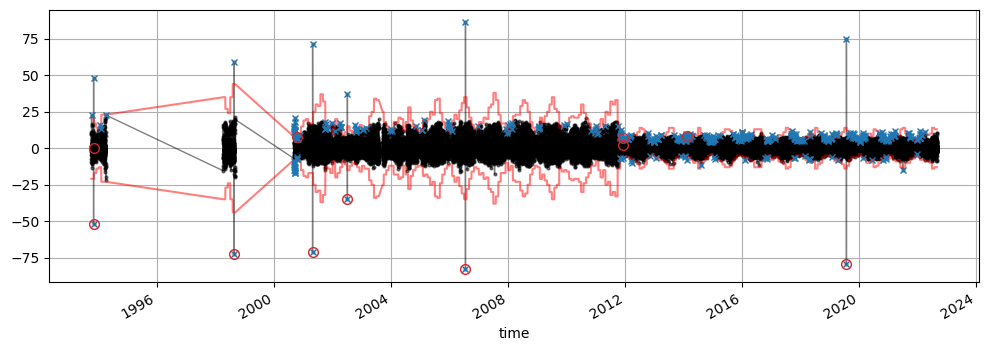

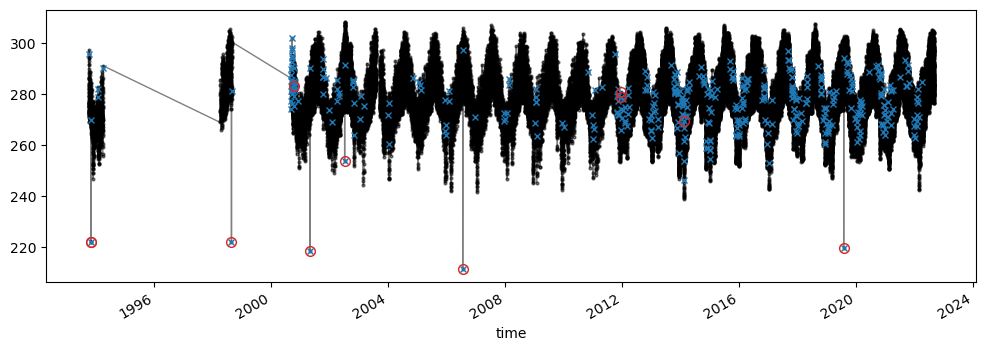

In [17]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

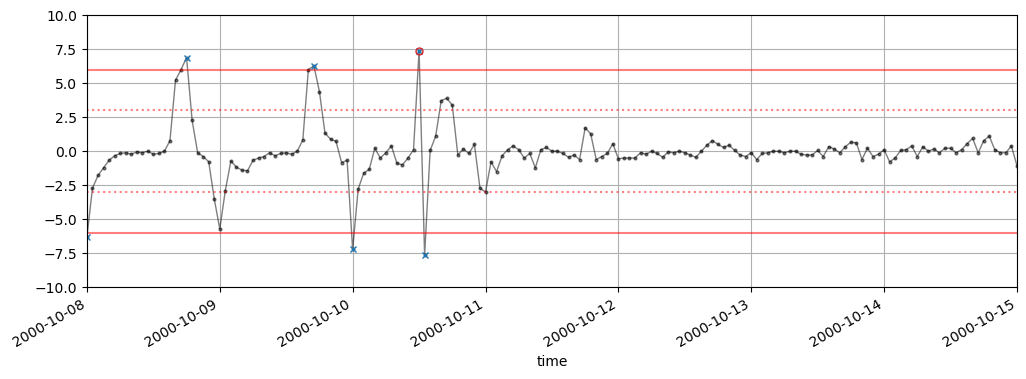

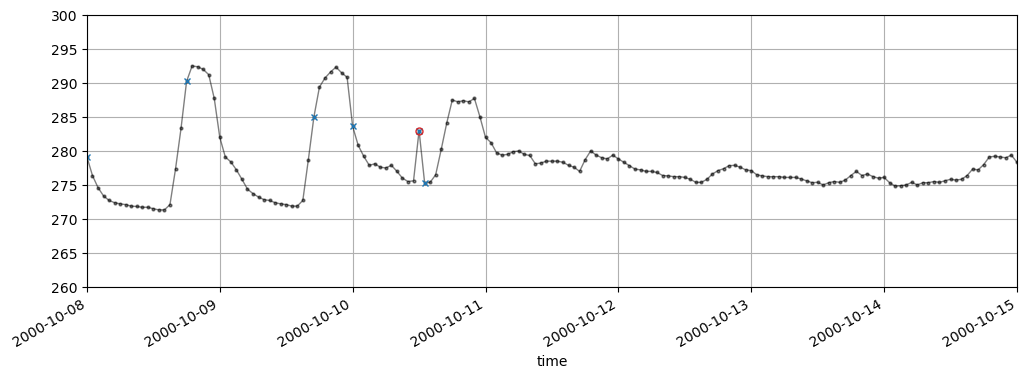

In [18]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(-.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(0.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2000-10-08"), np.datetime64("2000-10-15"))
ax.set_ylim(-10,10)
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2000-10-08"), np.datetime64("2000-10-15"))
ax.set_ylim(260,300)
ax.grid()

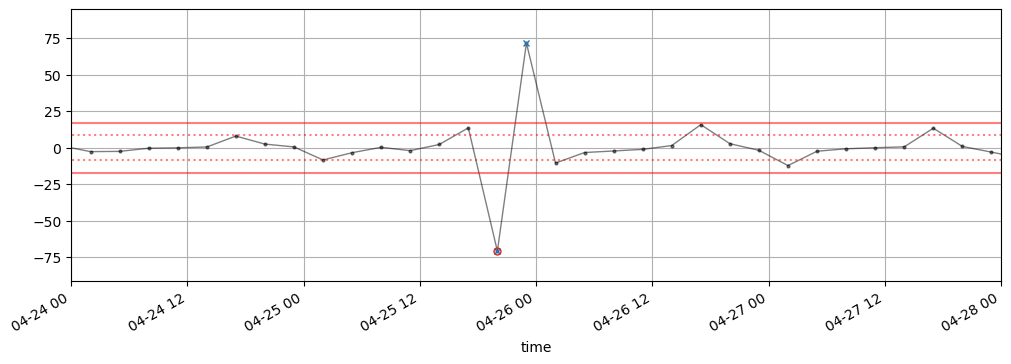

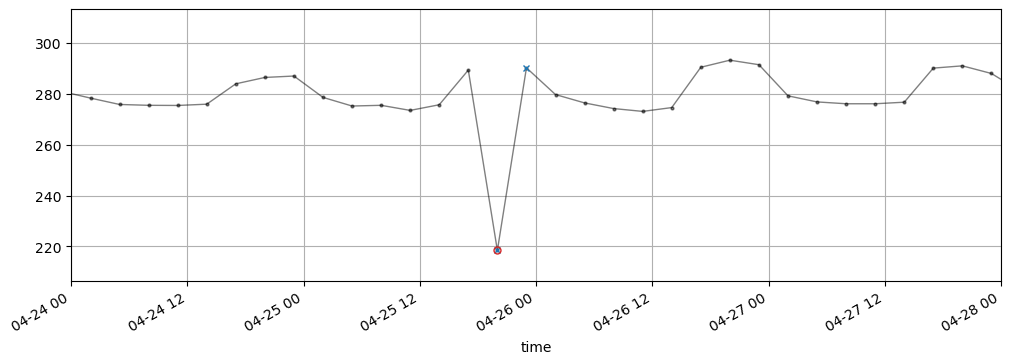

In [19]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(-.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(0.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2001-04-24"), np.datetime64("2001-04-28"))
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2001-04-24"), np.datetime64("2001-04-28"))
ax.grid()

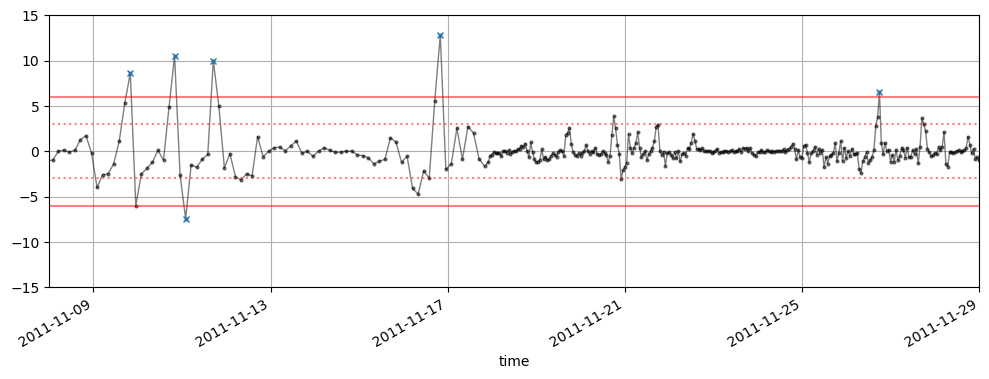

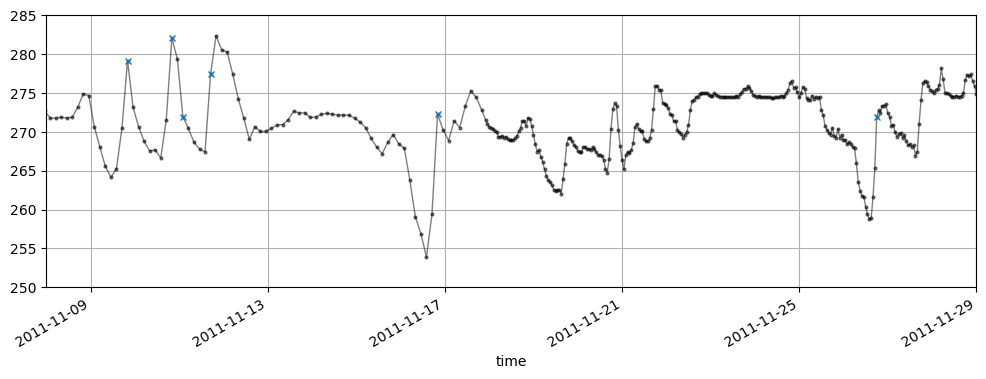

In [20]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(-.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(0.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2011-11-08"), np.datetime64("2011-11-29"))
ax.set_ylim(-15,15)
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2011-11-08"), np.datetime64("2011-11-29"))
ax.set_ylim(250,285)
ax.grid()

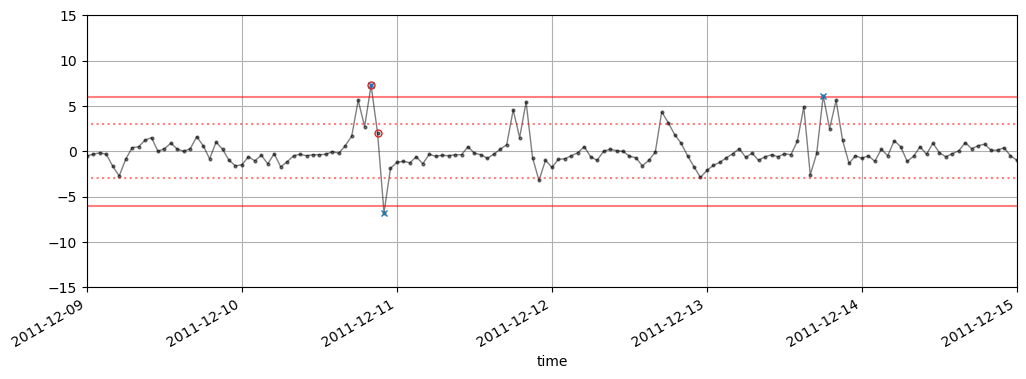

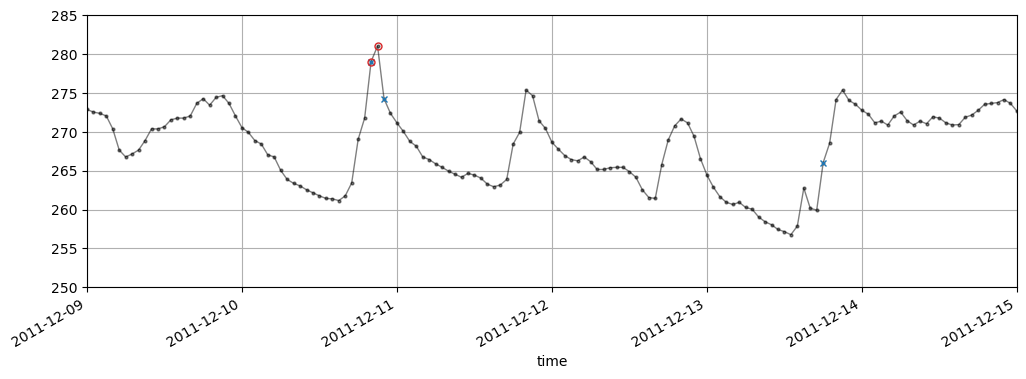

In [21]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(-.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(0.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2011-12-09"), np.datetime64("2011-12-15"))
ax.set_ylim(-15,15)
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2011-12-09"), np.datetime64("2011-12-15"))
ax.set_ylim(250,285)
ax.grid()

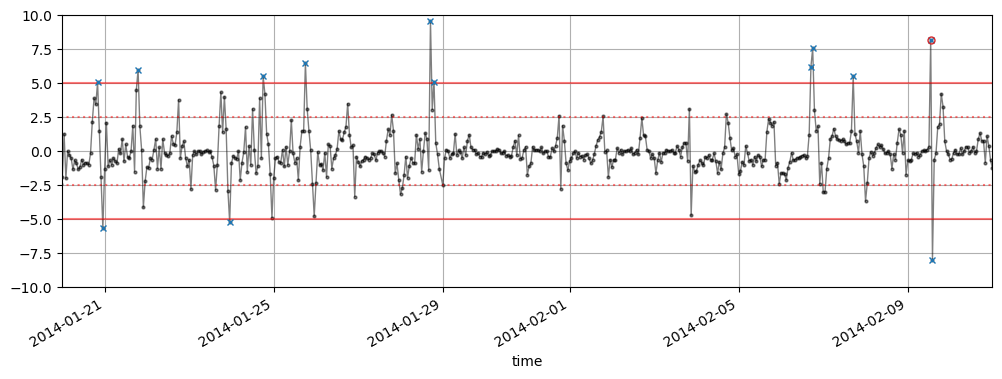

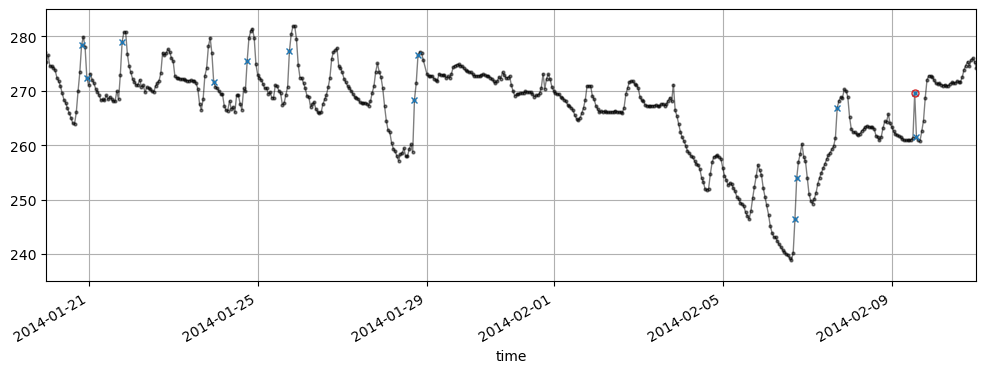

In [22]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(-.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(0.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2014-01-20"), np.datetime64("2014-02-11"))
ax.set_ylim(-10,10)
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2014-01-20"), np.datetime64("2014-02-11"))
ax.set_ylim(235,285)
ax.grid()

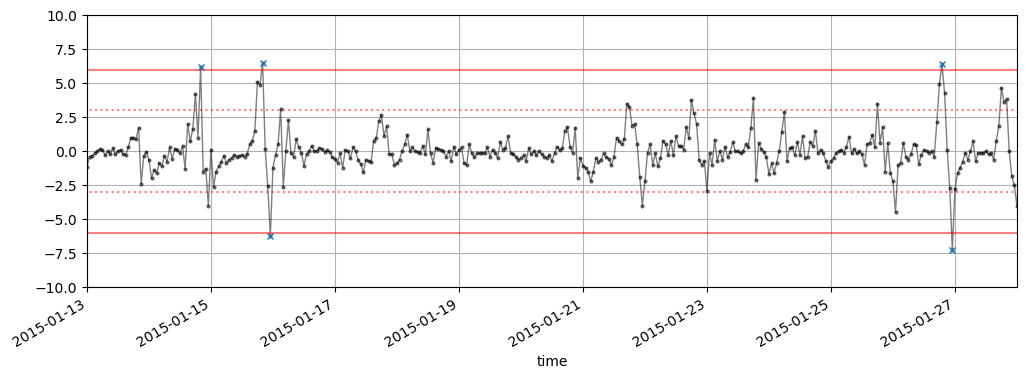

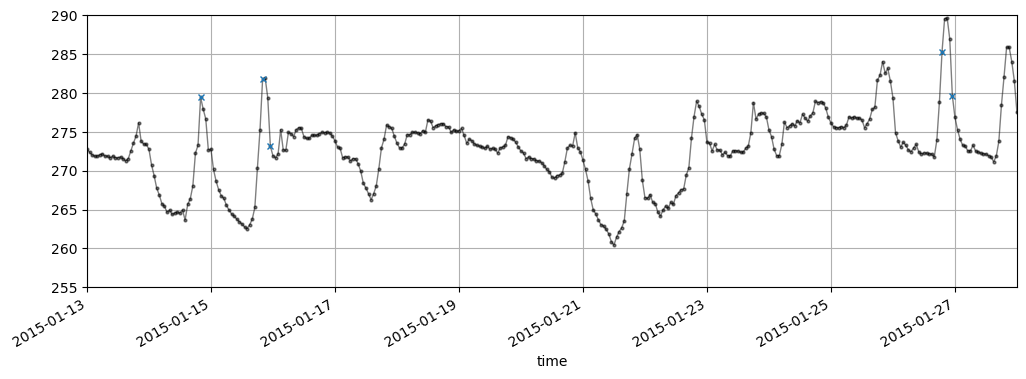

In [23]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(-.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="r", alpha=0.5)
(0.5*df['critical']).plot(ax=ax, ls=":", label="diff", color="r", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df['difference'][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2015-01-13"), np.datetime64("2015-01-28"))
ax.set_ylim(-10,10)
ax.grid()

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df[var][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
df[var][spikes].plot(ax=ax, marker="o", ms=5, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2015-01-13"), np.datetime64("2015-01-28"))
ax.set_ylim(255,290)
ax.grid()

### ASOSAWOS_72032204129

In [24]:
ds = xr.open_dataset('train_files/ASOSAWOS_72032204129.nc').isel(station=0)
df = ds[var].to_dataframe().dropna(subset=var).drop(columns=["lat","lon"])#.reset_index()

In [25]:
# df['abs_difference'] = np.abs(df[var].diff().fillna(0))
df['difference'] = df[var].diff().fillna(0)
# df['difference'] = (df[var]-df['y_fit']).diff().fillna(0)
df['date'] = df.index.values
df['time_diff'] = df['date'].diff().fillna(pd.Timedelta(0))
df['hours_diff'] = df['time_diff']/np.timedelta64(1, 'h')
dfbk = df.copy(deep=True)
df = df[np.logical_and(df['hours_diff'] > 0, df['hours_diff'] <= 10)]
df.head()

station     tas  difference  \
time                                                            
2006-01-01 00:30:00  ASOSAWOS_72032204129  276.15         0.0   
2006-01-01 00:50:00  ASOSAWOS_72032204129  276.15         0.0   
2006-01-01 01:10:00  ASOSAWOS_72032204129  276.15         0.0   
2006-01-01 01:30:00  ASOSAWOS_72032204129  276.15         0.0   
2006-01-01 01:50:00  ASOSAWOS_72032204129  276.15         0.0   

                                   date       time_diff  hours_diff  
time                                                                 
2006-01-01 00:30:00 2006-01-01 00:30:00 0 days 00:20:00    0.333333  
2006-01-01 00:50:00 2006-01-01 00:50:00 0 days 00:20:00    0.333333  
2006-01-01 01:10:00 2006-01-01 01:10:00 0 days 00:20:00    0.333333  
2006-01-01 01:30:00 2006-01-01 01:30:00 0 days 00:20:00    0.333333  
2006-01-01 01:50:00 2006-01-01 01:50:00 0 days 00:20:00    0.333333

<AxesSubplot:title={'center':'station = ASOSAWOS_72032204129'}, xlabel='time', ylabel='air_temperature\n[degree_Kelvin]'>

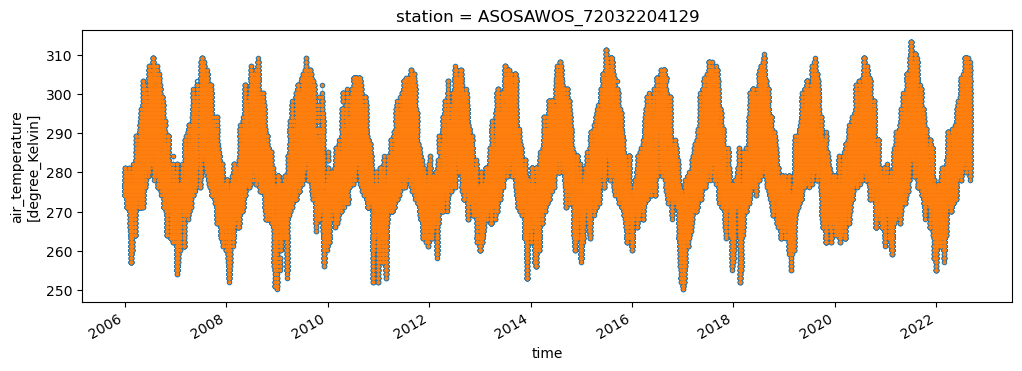

In [26]:
fig,ax = plt.subplots(figsize=(12,4))

ds[var].plot(ax=ax, marker=".", ms=6, lw=.1, mfc='none')
df[var].plot(ax=ax, marker=".", ms=3, lw=0)

In [27]:
# fig,ax = plt.subplots(figsize=(12,4))

# (df[var]).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
# ax.set_xlim(np.datetime64("2000-04-15"), np.datetime64("2000-06-01"))

In [28]:
# grouped = df.groupby([pd.Grouper(freq='M'), df['hours_diff']]) 
grouped = df.groupby(pd.Grouper(freq='M')) 

# grouped = df.groupby([pd.Grouper(freq='Y'), df['hours_diff']]) 
# grouped = df.groupby([pd.Grouper(freq='Y')]) 
# grouped = df.groupby([df['hours_diff']]) 

counts = grouped['difference'].transform("count")

# std = grouped['difference'].transform("median") + grouped['difference'].transform("std")

df['counts'] = counts
df = df[df['counts']>100]

# kwargs = {'rng':(15, 85),
# kwargs = {'rng':(25, 75),
#           'scale':1.0,
#           'nan_policy':'propagate',
#           'interpolation':'linear',
#          }
# kwargs = {'rng':(20, 80),}
kwargs = {}
iqr = grouped['difference'].transform(scipy.stats.iqr, **kwargs)
# abs_iqr = grouped['abs_difference'].transform(scipy.stats.iqr, **kwargs)
df['iqr'] = iqr
# df['abs_iqr'] = abs_iqr
# df['std'] = std

df['critical'] = np.ceil(6*df['iqr'])
# df['abs_critical'] = np.ceil(6*df['abs_iqr'])
df

# df.iloc[-16800:-16750]

station     tas  difference  \
time                                                            
2006-01-01 00:30:00  ASOSAWOS_72032204129  276.15         0.0   
2006-01-01 00:50:00  ASOSAWOS_72032204129  276.15         0.0   
2006-01-01 01:10:00  ASOSAWOS_72032204129  276.15         0.0   
2006-01-01 01:30:00  ASOSAWOS_72032204129  276.15         0.0   
2006-01-01 01:50:00  ASOSAWOS_72032204129  276.15         0.0   
...                                   ...     ...         ...   
2022-08-31 22:35:00  ASOSAWOS_72032204129  306.15         0.0   
2022-08-31 22:55:00  ASOSAWOS_72032204129  307.15         1.0   
2022-08-31 23:15:00  ASOSAWOS_72032204129  307.15         0.0   
2022-08-31 23:35:00  ASOSAWOS_72032204129  308.15         1.0   
2022-08-31 23:55:00  ASOSAWOS_72032204129  306.15        -2.0   

                                   date       time_diff  hours_diff  counts  \
time                                                                          
2006-01-01 00:30:00 2006-01-01 00:30:00 0 days 00:20:00    0.333333    2112   
2006-01-01 00:50:00 2006-01-01 00:50:00 0 days 00:20:00    0.333333    2112   
2006-01-01 01:10:00 2006-01-01 01:10:00 0 days 00:20:00    0.333333    2112   
2006-01-01 01:30:00 2006-01-01 01:30:00 0 days 00:20:00    0.333333    2112   
2006-01-01 01:50:00 2006-01-01 01:50:00 0 days 00:20:00    0.333333    2112   
...                                 ...             ...         ...     ...   
2022-08-31 22:35:00 2022-08-31 22:35:00 0 days 00:20:00    0.333333    2203   
2022-08-31 22:55:00 2022-08-31 22:55:00 0 days 00:20:00    0.333333    2203   
2022-08-31 23:15:00 2022-08-31 23:15:00 0 days 00:20:00    0.333333    2203   
2022-08-31 23:35:00 2022-08-31 23:35:00 0 days 00:20:00    0.333333    2203   
2022-08-31 23:55:00 2022-08-31 23:55:00 0 days 00:20:00    0.333333    2203   

                     iqr  critical  
time                                
2006-01-01 00:30:00  0.0       0.0  
2006-01-01 00:50:00  0.0       0.0  
2006-01-01 01:10:00  0.0       0.0  
2006-01-01 01:30:00  0.0       0.0  
2006-01-01 01:50:00  0.0       0.0  
...                  ...       ...  
2022-08-31 22:35:00  1.0       6.0  
2022-08-31 22:55:00  1.0       6.0  
2022-08-31 23:15:00  1.0       6.0  
2022-08-31 23:35:00  1.0       6.0  
2022-08-31 23:55:00  1.0       6.0  

[426573 rows x 9 columns]

In [29]:
df['potential_spike'] = np.abs(df['difference'])>df['critical']
len(np.where(df['potential_spike'])[0])

118654

<AxesSubplot:xlabel='time'>

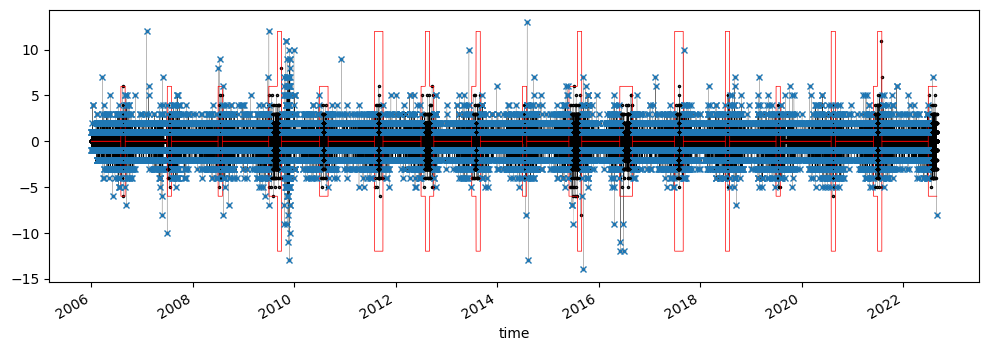

In [30]:
fig,ax = plt.subplots(figsize=(12,4))

(df['difference']).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
(df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
(-1*df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")

# fig,ax = plt.subplots(figsize=(12,4))

# (df['abs_difference']).plot(ax=ax, marker=".", ms=2, lw=.1, mfc='none', color="k")
# (df['abs_critical']).plot(ax=ax, lw=.5, color="red")

In [31]:
# fig,ax = plt.subplots(figsize=(12,4))

# (dfbk['difference']).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
# (df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
# (-1*df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
# df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
# ax.set_xlim(np.datetime64("2000-04-15"), np.datetime64("2000-06-01"))
# axt = ax.twinx()
# df['hours_diff'].plot(ax=axt)

In [32]:
# fig,ax = plt.subplots(figsize=(12,4))

# (dfbk['difference']).plot(ax=ax, marker=".", ms=3, lw=.1, mfc='none', color="k")
# (df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
# (-1*df['critical']).plot(ax=ax, lw=.5, ls="-", color="red")
# df['difference'][df['potential_spike']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
# ax.set_xlim(np.datetime64("2000-04-25"), np.datetime64("2000-05-05"))
# axt = ax.twinx()
# df['hours_diff'].plot(ax=axt)

In [33]:
spikes = potential_spike_check(df['potential_spike'], df['difference'], df['critical'], df['hours_diff'])
print(len(np.where(spikes)[0]))
df['spikes'] = spikes
df.head(5)

0


station     tas  difference  \
time                                                            
2006-01-01 00:30:00  ASOSAWOS_72032204129  276.15         0.0   
2006-01-01 00:50:00  ASOSAWOS_72032204129  276.15         0.0   
2006-01-01 01:10:00  ASOSAWOS_72032204129  276.15         0.0   
2006-01-01 01:30:00  ASOSAWOS_72032204129  276.15         0.0   
2006-01-01 01:50:00  ASOSAWOS_72032204129  276.15         0.0   

                                   date       time_diff  hours_diff  counts  \
time                                                                          
2006-01-01 00:30:00 2006-01-01 00:30:00 0 days 00:20:00    0.333333    2112   
2006-01-01 00:50:00 2006-01-01 00:50:00 0 days 00:20:00    0.333333    2112   
2006-01-01 01:10:00 2006-01-01 01:10:00 0 days 00:20:00    0.333333    2112   
2006-01-01 01:30:00 2006-01-01 01:30:00 0 days 00:20:00    0.333333    2112   
2006-01-01 01:50:00 2006-01-01 01:50:00 0 days 00:20:00    0.333333    2112   

                     iqr  critical  potential_spike  spikes  
time                                                         
2006-01-01 00:30:00  0.0       0.0            False   False  
2006-01-01 00:50:00  0.0       0.0            False   False  
2006-01-01 01:10:00  0.0       0.0            False   False  
2006-01-01 01:30:00  0.0       0.0            False   False  
2006-01-01 01:50:00  0.0       0.0            False   False

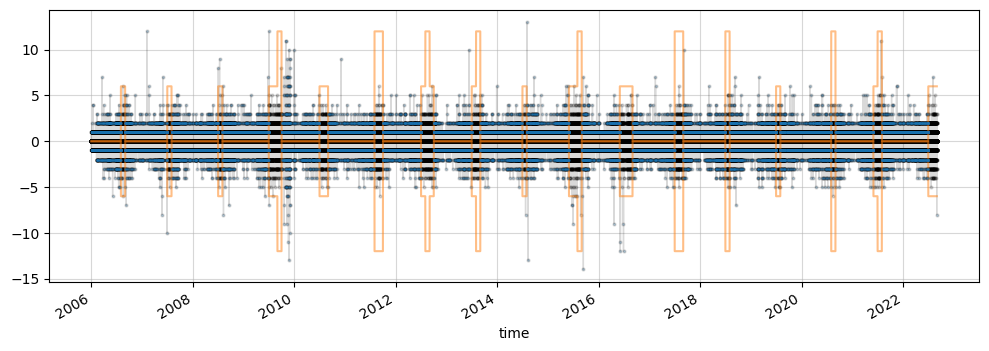

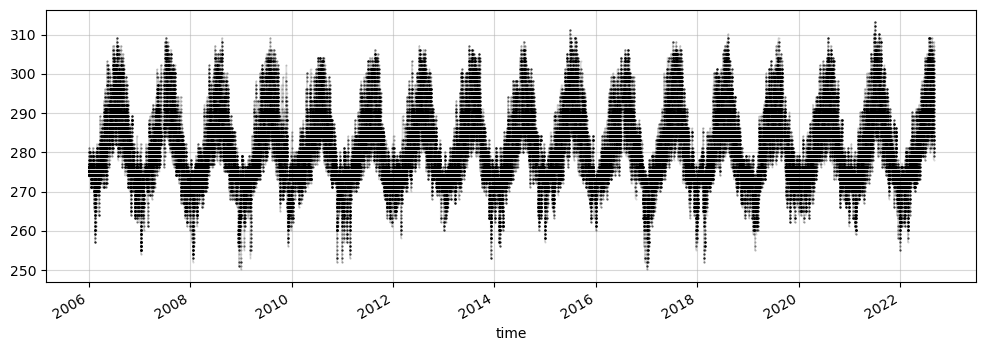

In [34]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.15)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="C1", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="C1", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker=".", ms=2, lw=0, color="C0", alpha=0.15)
df['difference'][df['spikes']].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
ax.grid(alpha=0.5)

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=1, lw=1, label="diff", color="k", alpha=0.15)
df[var][df['spikes']].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
ax.grid(alpha=0.5)

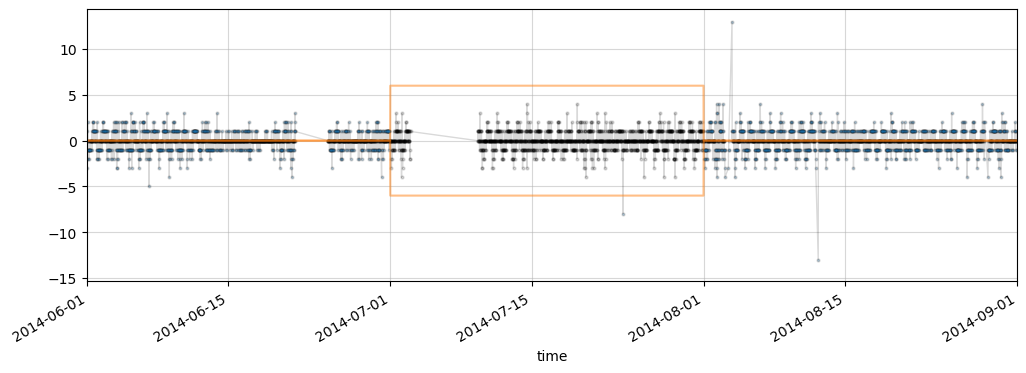

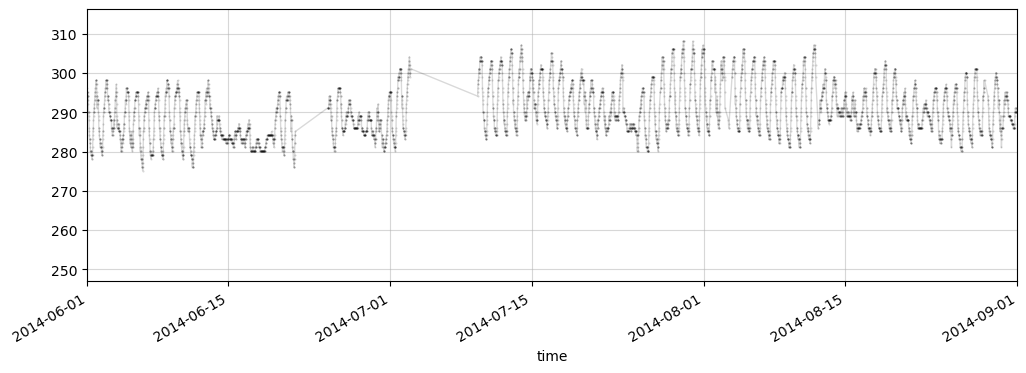

In [35]:
fig,ax = plt.subplots(figsize=(12,4))
df['difference'].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.15)
( -1*df['critical']).plot(ax=ax, ls="-", label="diff", color="C1", alpha=0.5)
(    df['critical']).plot(ax=ax, ls="-", label="diff", color="C1", alpha=0.5)
df['difference'][df['potential_spike']].plot(ax=ax, marker=".", ms=2, lw=0, color="C0", alpha=0.15)
df['difference'][df['spikes']].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2014-06-01"), np.datetime64("2014-09-01"))
ax.grid(alpha=0.5)

fig,ax = plt.subplots(figsize=(12,4))
df[var].plot(ax=ax, marker=".", ms=1, lw=1, label="diff", color="k", alpha=0.15)
df[var][df['spikes']].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
ax.set_xlim(np.datetime64("2014-06-01"), np.datetime64("2014-09-01"))
ax.grid(alpha=0.5)

## Tweaks

- Hourly data?
- Number of data for each month/time difference (grouping) to be valid?
- Number of IQR
- Before/after peak thresholds
- Group by time diff or not

## Detect spikes function

In [36]:
def detect_spikes(df, var):
    """
    
    """
    
    df = df.copy(deep=True)
    
    # Calculate difference in var values
    df[var+'_difference'] = df[var].diff().fillna(0)
    
    # Calculate dates
    df['date'] = df.index.values
    
    # Calculate time difference
    df['time_diff'] = df['date'].diff().fillna(pd.Timedelta(0))
    
    # Calculate time differece in hours
    df['hours_diff'] = df['time_diff']/np.timedelta64(1, 'h')
    df = df[np.logical_and(df['hours_diff'] > 0, df['hours_diff'] <= 12)]
    
    # Group by month to avoid strong seasonal cycle
    # grouped = df.groupby([pd.Grouper(freq='M'), df['hours_diff']]) 
    grouped = df.groupby(pd.Grouper(freq='M')) 

    # Count number of data per month
    counts = grouped[var+'_difference'].transform("count")
    df[var+'_counts'] = counts
    # Keep only months with more than 50 values to be statistically valid
    df = df[df[var+'_counts']>50]

    # Define modified IQR 
    # kwargs = {'rng':(20, 80),}
    kwargs = {}
    
    # Calculate iqr
    iqr = grouped[var+'_difference'].transform(scipy.stats.iqr, **kwargs)
    df[var+'_iqr'] = iqr

    # Calculate critical value as rounded-up 6 times IQR
    df[var+'_critical'] = np.ceil(6*df[var+'_iqr'])
    
    # Find potential spike values where var diff is higher than the critical value
    df[var+'_potential_spikes'] = np.abs(df[var+'_difference'])>df[var+'_critical']

    # Filter real spikes using `potential_spike_check` function
    spikes = potential_spike_check(df[var+'_potential_spikes'], df[var+'_difference'], df[var+'_critical'], df['hours_diff'])
    df[var+'_spikes'] = spikes
    
    return df

### Variable: tas

In [37]:
var = "tas"
df = ds.to_dataframe().dropna(subset=var).drop(columns=["lat","lon","elevation","station"])
df

ps     tas    tdps  sfcWind  sfcWind_dir  \
time                                                                 
2006-01-01 00:10:00      NaN  276.15  272.15      3.1         40.0   
2006-01-01 00:30:00      NaN  276.15  273.15      2.1         30.0   
2006-01-01 00:50:00  91610.0  276.15  272.15      1.5         40.0   
2006-01-01 01:10:00      NaN  276.15  272.15      0.0          NaN   
2006-01-01 01:30:00      NaN  276.15  273.15      0.0          NaN   
...                      ...     ...     ...      ...          ...   
2022-08-31 22:35:00  93830.0  306.15  282.15      1.5        100.0   
2022-08-31 22:55:00      NaN  307.15  282.15      2.1        110.0   
2022-08-31 23:15:00      NaN  307.15  282.15      2.1        110.0   
2022-08-31 23:35:00      NaN  308.15  280.15      0.0          NaN   
2022-08-31 23:55:00      NaN  306.15  284.15      0.0          NaN   

                    qaqc_process ps_qc  ps_altimeter ps_altimeter_qc psl_qc  \
time                                                                          
2006-01-01 00:10:00         V020     9       99090.0               1      9   
2006-01-01 00:30:00         V020     9       99020.0               1      9   
2006-01-01 00:50:00         V020     5       99020.0               5      9   
2006-01-01 01:10:00         V020     9       99020.0               1      9   
2006-01-01 01:30:00         V020     9       99020.0               1      9   
...                          ...   ...           ...             ...    ...   
2022-08-31 22:35:00         V020     5      101390.0               5      9   
2022-08-31 22:55:00         V020     9      101320.0               1      9   
2022-08-31 23:15:00         V020     9      101320.0               1      9   
2022-08-31 23:35:00         V020     9      101290.0               1      9   
2022-08-31 23:55:00         V020     9      101250.0               1      9   

                    tas_qc tdps_qc sfcWind_qc sfcWind_method sfcWind_dir_qc  
time                                                                         
2006-01-01 00:10:00      1       1          1              N              1  
2006-01-01 00:30:00      1       1          1              N              1  
2006-01-01 00:50:00      C       C          5              N              5  
2006-01-01 01:10:00      1       1          1              C              9  
2006-01-01 01:30:00      1       1          1              C              9  
...                    ...     ...        ...            ...            ...  
2022-08-31 22:35:00      5       5          5              N              5  
2022-08-31 22:55:00      1       1          1              N              1  
2022-08-31 23:15:00      1       1          1              N              1  
2022-08-31 23:35:00      1       1          1              C              9  
2022-08-31 23:55:00      1       1          1              C              9  

[426647 rows x 15 columns]

In [38]:
new_df = detect_spikes(df, var=var)
len(df), len(new_df)

(426647, 426582)

<AxesSubplot:xlabel='time'>

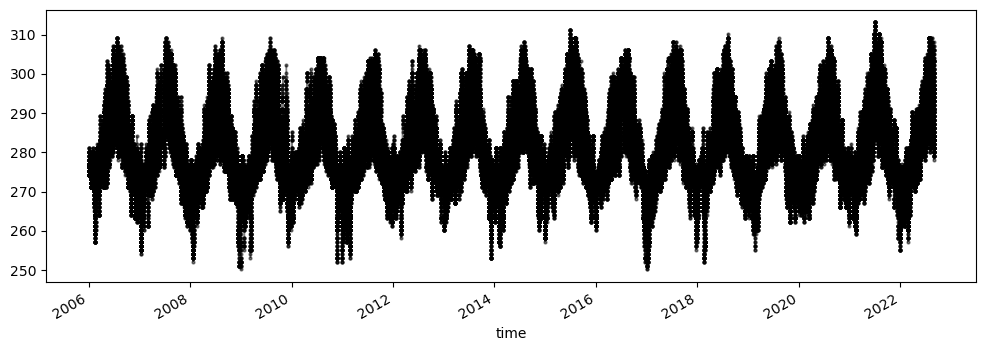

In [39]:
fig,ax = plt.subplots(figsize=(12,4))

new_df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
# new_df[var][new_df[var+'_potential_spikes']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
new_df[var][new_df[var+"_spikes"]].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

In [40]:
ind = new_df.index[np.where(new_df[var+"_spikes"])[0]]
ind

DatetimeIndex([], dtype='datetime64[ns]', name='time', freq=None)

<AxesSubplot:xlabel='time'>

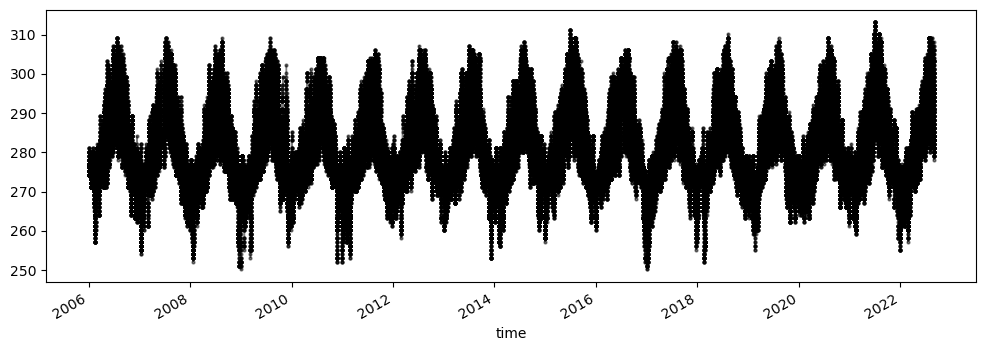

In [41]:
fig,ax = plt.subplots(figsize=(12,4))

df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
df.loc[ind, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
new_df[var][new_df[var+"_spikes"]].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

### Variable: tdps

In [42]:
var = "tdps"
var = "tas"
ds = xr.open_dataset('train_files/ASOSAWOS_72032204129.nc').isel(station=0)
df = ds.to_dataframe().dropna(subset=var).drop(columns=["lat","lon","elevation","station"])
df.head(5)

ps     tas    tdps  sfcWind  sfcWind_dir  \
time                                                                 
2006-01-01 00:10:00      NaN  276.15  272.15      3.1         40.0   
2006-01-01 00:30:00      NaN  276.15  273.15      2.1         30.0   
2006-01-01 00:50:00  91610.0  276.15  272.15      1.5         40.0   
2006-01-01 01:10:00      NaN  276.15  272.15      0.0          NaN   
2006-01-01 01:30:00      NaN  276.15  273.15      0.0          NaN   

                    qaqc_process ps_qc  ps_altimeter ps_altimeter_qc psl_qc  \
time                                                                          
2006-01-01 00:10:00         V020     9       99090.0               1      9   
2006-01-01 00:30:00         V020     9       99020.0               1      9   
2006-01-01 00:50:00         V020     5       99020.0               5      9   
2006-01-01 01:10:00         V020     9       99020.0               1      9   
2006-01-01 01:30:00         V020     9       99020.0               1      9   

                    tas_qc tdps_qc sfcWind_qc sfcWind_method sfcWind_dir_qc  
time                                                                         
2006-01-01 00:10:00      1       1          1              N              1  
2006-01-01 00:30:00      1       1          1              N              1  
2006-01-01 00:50:00      C       C          5              N              5  
2006-01-01 01:10:00      1       1          1              C              9  
2006-01-01 01:30:00      1       1          1              C              9

In [43]:
new_df = detect_spikes(df, var=var)
drop_vars = ["qaqc_process","ps_qc","ps_altimeter_qc","sfcWind_qc","sfcWind_dir_qc","psl_qc","tas_qc","sfcWind_method","tdps_qc"]
new_df.drop(columns=drop_vars).head(5)
len(df), len(new_df)

(426647, 426582)

In [44]:
pd.Series(df.index.values).diff()

0                    NaT
1        0 days 00:20:00
2        0 days 00:20:00
3        0 days 00:20:00
4        0 days 00:20:00
               ...      
426642   0 days 00:20:00
426643   0 days 00:20:00
426644   0 days 00:20:00
426645   0 days 00:20:00
426646   0 days 00:20:00
Length: 426647, dtype: timedelta64[ns]

<AxesSubplot:xlabel='time'>

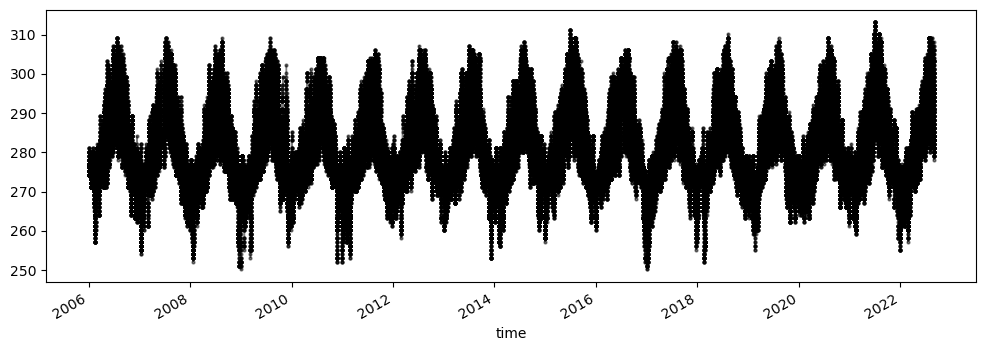

In [45]:
fig,ax = plt.subplots(figsize=(12,4))

df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
# new_df[var][new_df[var+'_potential_spikes']].plot(ax=ax, marker="x", ms=5, lw=0, color="C0")
# new_df[var][new_df[var+"_spikes"]].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

## Unusual Large Jumps Function

In [46]:
# def run_qaqc_pipeline(ds, network, file_name, 
#                       errors, station, end_api, 
#                       verbose=True):
def xarray_to_pandas_qaqc(ds):
    """
    """

    ## Add qc_flag variable for all variables, including elevation; 
    ## defaulting to nan for fill value that will be replaced with qc flag
    exclude_qaqc = ["time", "station", "lat", "lon", 
                    "qaqc_process", "sfcWind_method"] # lat and lon have a different qc check

    raw_qc_vars = [] # qc_variable for each data variable, will vary station to station
    era_qc_vars = [] # our qc variable
    for var in ds.data_vars:
        if 'q_code' in var:
            raw_qc_vars.append(var) # raw qc variable, need to keep for comparison, then drop
        if '_qc' in var:
            raw_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars:
            qc_var = var + "_eraqc" # variable/column label
            era_qc_vars.append(qc_var)
            # adds new variable in shape of original variable with designated nan fill value
            ds = ds.assign({qc_var: xr.ones_like(ds[var])*np.nan})

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var:ds[var].attrs for var in list(ds.data_vars.keys())}

    df = ds.to_dataframe()
    df['anemometer_height_m'] = np.ones(ds['time'].shape)*ds.anemometer_height_m
    df['thermometer_height_m'] = np.ones(ds['time'].shape)*ds.thermometer_height_m
    
    return df

In [47]:
def qaqc_world_record(df, verbose=True):
    '''
    Checks if temperature, dewpoint, windspeed, or sea level pressure are outside North American world records
    If outside minimum or maximum records, flags values
    '''
    try:
        # world records from HadISD protocol, cross-checked with WMO database
        # https://wmo.asu.edu/content/world-meteorological-organization-global-weather-climate-extremes-archive
        T_X = {"North_America":329.92} #K
        T_N = {"North_America":210.15} #K
        D_X = {"North_America":329.85} #K
        D_N = {"North_America":173.15} #K
        W_X = {"North_America":113.2} #m/s
        W_N = {"North_America":0.} #m/s
        S_X = {"North_America":108330} #Pa
        S_N = {"North_America":87000} #Pa

        maxes = {"tas": T_X, "tdps": D_X, "tdps_derived": D_X, "sfcWind": W_X, "psl": S_X}
        mins = {"tas": T_N, "tdps": D_N, "tdps_derived": D_N, "sfcWind": W_N, "psl": S_N}

        # variable names to check against world record limits
        wr_vars = ['tas', 'tdps_derived', 'tdps', 'sfcWind', 'psl']

        for var in wr_vars:
            if var in list(df.columns):
                isOffRecord = np.logical_or(df[var] < mins[var]['North_America'],
                                            df[var] > maxes[var]['North_America'])
                if isOffRecord.any():
                    df.loc[isOffRecord, var + '_eraqc'] = 11
        return df
    except Exception as e:
        if verbose:
            print("qaqc_world_record failed with Exception: {}".format(e))
        return None

In [48]:
def unusual_large_jumps(df):
    """
    
    Flag meaninig:
        22,qaqc_unusual_large_jumps,Unusual jump (spike) in variable
    """
    
    check_vars = ["tas", "tdps", "ps", "slp"]
    variables = [var for var in check_vars if var in df.columns]
    
    for var in variables:
        new_df = df.copy(deep=True)
        new_df = new_df.dropna(subset=var).drop(columns=["lat","lon","elevation","station"])
        valid = np.where(np.isnan(new_df[var+"_eraqc"]))[0]
        new_df = new_df.iloc[valid]
        new_df = detect_spikes(new_df, var=var)
        ind = new_df.index[np.where(new_df[var+"_spikes"])[0]]      
        df.loc[ind, var+"_eraqc"] = 22
        
    return df

### SNOTEL_835

In [49]:
ds = xr.open_dataset('train_files/SNOTEL_835.nc').isel(station=0)
df = ds.to_dataframe().dropna(subset=var)
df = xarray_to_pandas_qaqc(ds)
df.head(5)

tas      pr tas_qc pr_qc  elevation     station  \
time                                                                          
1980-01-01 08:00:00         NaN  317.50    nan     E    1706.88  SNOTEL_835   
1980-01-02 08:00:00         NaN  317.50    nan     E    1706.88  SNOTEL_835   
1980-01-03 08:00:00         NaN  317.50    nan     E    1706.88  SNOTEL_835   
1980-01-04 08:00:00         NaN  320.04    nan     E    1706.88  SNOTEL_835   
1980-01-04 12:00:00  258.761111  320.04      V     E    1706.88  SNOTEL_835   

                          lat        lon  tas_eraqc  pr_eraqc  \
time                                                            
1980-01-01 08:00:00  46.14287 -114.44755        NaN       NaN   
1980-01-02 08:00:00  46.14287 -114.44755        NaN       NaN   
1980-01-03 08:00:00  46.14287 -114.44755        NaN       NaN   
1980-01-04 08:00:00  46.14287 -114.44755        NaN       NaN   
1980-01-04 12:00:00  46.14287 -114.44755        NaN       NaN   

                     elevation_eraqc  anemometer_height_m  \
time                                                        
1980-01-01 08:00:00              NaN                  1.5   
1980-01-02 08:00:00              NaN                  1.5   
1980-01-03 08:00:00              NaN                  1.5   
1980-01-04 08:00:00              NaN                  1.5   
1980-01-04 12:00:00              NaN                  1.5   

                     thermometer_height_m  
time                                       
1980-01-01 08:00:00                   NaN  
1980-01-02 08:00:00                   NaN  
1980-01-03 08:00:00                   NaN  
1980-01-04 08:00:00                   NaN  
1980-01-04 12:00:00                   NaN

In [50]:
new_df = qaqc_world_record(df)
np.where(~np.isnan(new_df.tas_eraqc))

(array([], dtype=int64),)

In [51]:
new_df = unusual_large_jumps(new_df)
np.where(~np.isnan(new_df.tas_eraqc))

(array([ 12202,  12203,  17333,  19372,  21418,  26064,  39844,  55988,
         55989,  74987, 122887]),)

<AxesSubplot:xlabel='time'>

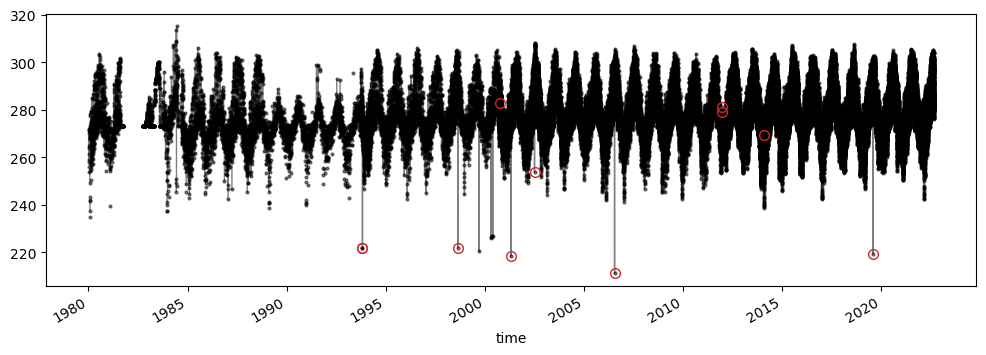

In [52]:
fig,ax = plt.subplots(figsize=(12,4))

var = "tas"
# ind = np.where()

new_df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
new_df.loc[df[var+"_eraqc"]==22, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")
# new_df[var][new_df[var+"_spikes"]].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

### RAWS_TOGC1

In [53]:
check_vars = ["tas", "tdps", "ps", "slp"]

In [54]:
ds = xr.open_dataset('train_files/RAWS_TOGC1.nc').isel(station=0)
print([var for var in list(ds.data_vars) if var in check_vars])
df = xarray_to_pandas_qaqc(ds)
new_df = qaqc_world_record(df)
print(len(np.where(~np.isnan(new_df.tas_eraqc))[0]))
new_df = unusual_large_jumps(new_df)
print(len(np.where(~np.isnan(new_df.tas_eraqc))[0]))

['tas']
0
1


<AxesSubplot:xlabel='time'>

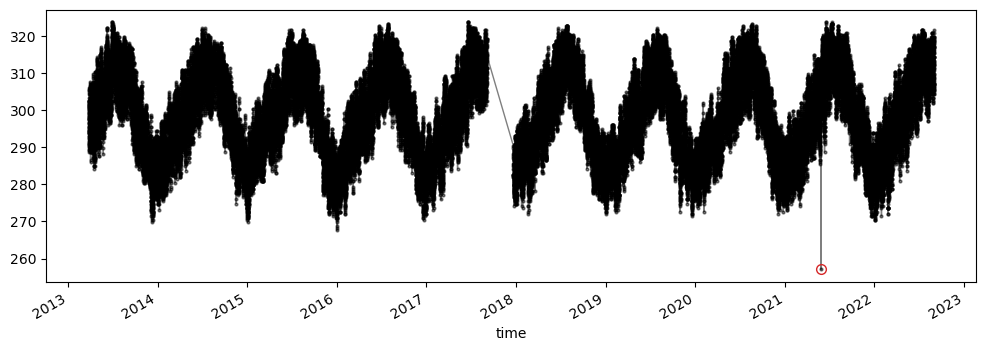

In [55]:
fig,ax = plt.subplots(figsize=(12,4))

var = "tas"
new_df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
new_df.loc[df[var+"_eraqc"]==22, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

### ASOSAWOS_72032204129

In [56]:
ds = xr.open_dataset('train_files/ASOSAWOS_72032204129.nc').isel(station=0)
print([var for var in list(ds.data_vars) if var in check_vars])
df = xarray_to_pandas_qaqc(ds)
new_df = qaqc_world_record(df)
print(len(np.where(~np.isnan(new_df.tas_eraqc))[0]))
new_df = unusual_large_jumps(new_df)
print(len(np.where(~np.isnan(new_df.tas_eraqc))[0]))

['ps', 'tas', 'tdps']
0
0


<AxesSubplot:xlabel='time'>

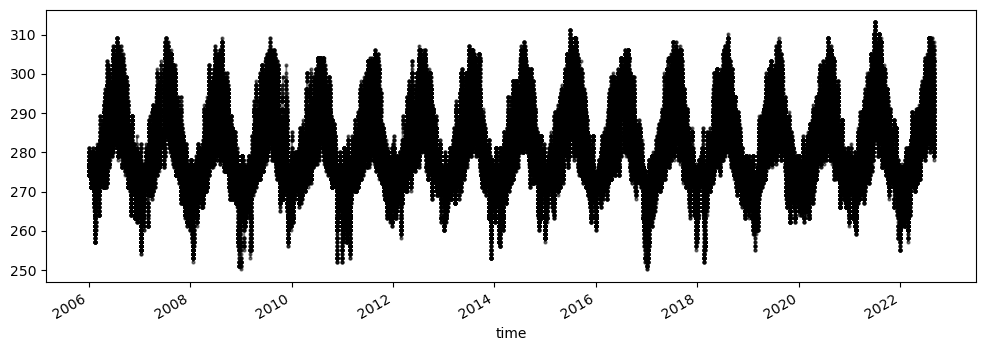

In [57]:
fig,ax = plt.subplots(figsize=(12,4))

var = "tas"
new_df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
new_df.loc[df[var+"_eraqc"]==22, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

<AxesSubplot:xlabel='time'>

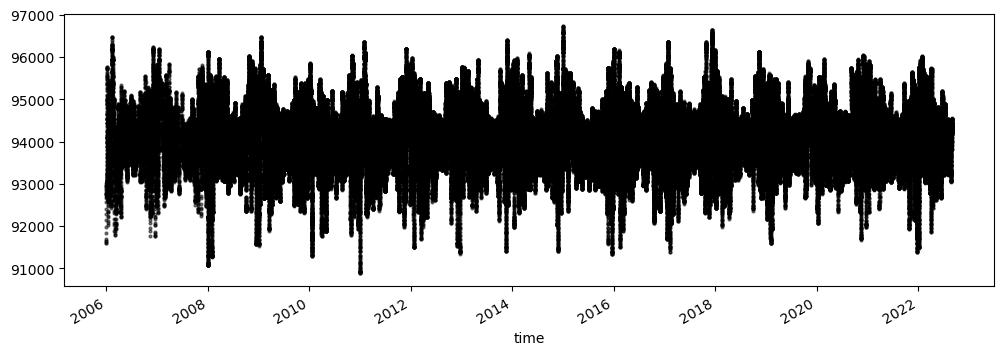

In [58]:
fig,ax = plt.subplots(figsize=(12,4))

var = "ps"
new_df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
new_df.loc[df[var+"_eraqc"]==22, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

<AxesSubplot:xlabel='time'>

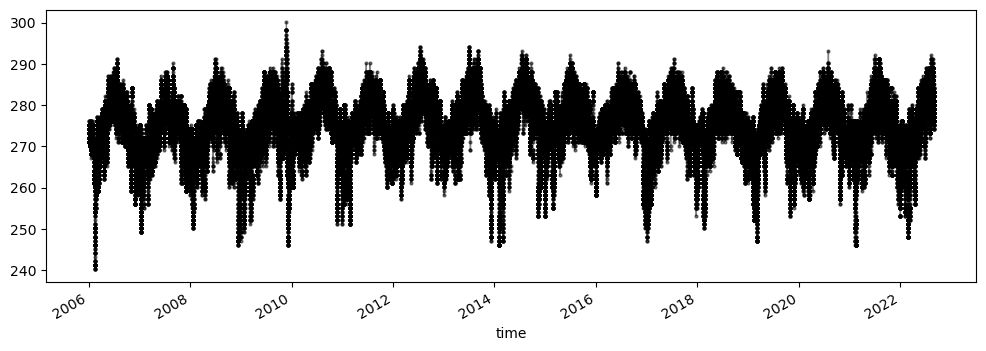

In [59]:
fig,ax = plt.subplots(figsize=(12,4))

var = "tdps"
new_df[var].plot(ax=ax, marker=".", ms=4, lw=1, label="diff", color="k", alpha=0.5)
new_df.loc[df[var+"_eraqc"]==22, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3")

## Takeaway points:

- It is crucial to apply other QAQC functions beforehand, otherwise this algorithm fails.
- It could be much more consistent and robust if data were in hourly format
- Is it worth it to do make data hourly at some point before this during the QAQC pipeline?